In [1]:
am_scale = 1

In [2]:
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd; from dtw import dtw; import librosa
from speech_pause_indicator import speech as original_speech; import itertools; import statistics
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
def downsample(query, ratio):
    
    # Scale the amplitudes by dividing each amplitude over the largest amplitude magnitude
    max_m = np.abs(max(query))
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)]/max_m)
    return res

In [4]:
# Maximum dtw distance = number of points in the alignment path * largest difference between amplitude of x and y

def normalize_distance(x, y, path, dist, method, am_scale = am_scale):
    plt.figure(figsize=(5, 3))
    nor_dist = dist / (am_scale * 2* len(path[0]))
    return nor_dist
    
# unit of distance = amplitude / portion of the alignment path

In [5]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, am_scale = am_scale, **kwargs):
    
    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', None)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]*max_am) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result

In [6]:
def return_common_seg(path, speech_x, speech_y):
    xs = path[0]
    ys = path[1]
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    # length of path = len(path[0]) = len(path[1])

    common_arr = [0] # multiplication of speech indicator of the input speech indicator functions
    common_seg = {} # store the list of speech and pause segments
    plt_index = {}
    
    # calculate common segmentation based on aligned curve
    for i in range(1, len(path[0])):
        index_original_x = int(xs[i]/len(xs)*len(speech_x))
        index_original_y = int(ys[i]/len(ys)*len(speech_y))
        sp1 = speech_x[index_original_x]
        sp2 = speech_y[index_original_y]
        sp_now = sp1*sp2
        
        if common_arr[-1] == 0 and sp_now == 1:
            # start of an aligned speech segment 
            plt_index['index in curve ' + str(i) + ' speech starts'] = [index_original_x, index_original_y]
            
        elif common_arr[-1] == 1 and sp_now == 0:
            # end of aligned speech segment / start of an aligned pause segment
            plt_index['index in curve ' + str(i) + ' pause starts'] = [index_original_x, index_original_y]          
            
        common_arr.append(sp_now)

    # Initialize matrix based on common segmentation, calculated from common segmentation
    counter = 0
    for j in range(1, len(common_arr)):
        counter = counter + 1
        if common_arr[j-1] == 0 and common_arr[j] == 1:
            common_seg[counter] = 'speech'
        if common_arr[j-1] == 1 and common_arr[j] == 0:
            common_seg[counter] = 'pause'
    
    return list(plt_index.values())

In [7]:
def make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, am_scale = am_scale, **kwargs):
    
    input_min_amp1 = kwargs.get('input_min_amp1', None)
    input_min_amp2 = kwargs.get('input_min_amp2', None)
    input_min_pause = kwargs.get('input_min_pause', None)
    
    file1_path = capstone_dir + "/py_converted/" + file1 ; file2_path = capstone_dir + "/py_converted/" + file2
    
    samplerate, query = wavfile.read(file1_path) ; samplerate, ref = wavfile.read(file2_path)
    ratio = samplerate/sr
    # If input sr = 4410, then ratio = 44100/4410 = 10 (samplerate from py_converted is always 44100)
    
    # Downsample the arrays to specified sample rate
    original_x = downsample(query, ratio)
    original_y = downsample(ref, ratio)
    
    smooth_x = [] # Store smoothened sample array
    smooth_y = [] # Store smoothened ref array
    
    # Rolling average on original_x and original_y. Store results in smooth_x, smooth_y
    # The fps here is the new fps after downsampling 
    frame_per_window = sr * window_len/1000 # Do smoothening on the query and ref
    
    for i in range(len(original_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(original_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(original_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(original_x[int(i1) : int(i2)]))
        smooth_x.append(num)
        
    for i in range(len(original_y)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(original_y) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(original_y)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(original_y[int(i1) : int(i2)]))
        smooth_y.append(num)
        
    smooth_x = smooth_x[int(sr*seg1_1): int(sr*seg1_2)]
    smooth_y = smooth_y[int(sr*seg2_1): int(sr*seg2_2)]       
        
    original_x = query[int(sr*seg1_1): int(sr*seg1_2)]
    original_y = ref[int(sr*seg2_1): int(sr*seg2_2)]       
    
    # Get speech indicator for the two samples
    speech_x = speech(smooth_x, query, seg1_1, seg1_2, sr, frame_per_window, 
                     input_min_amp = input_min_amp1,
                     input_min_pause = input_min_pause)
    
    speech_y = speech(smooth_y, ref, seg2_1, seg2_2, sr, frame_per_window, 
                   input_min_amp = input_min_amp2, 
                   input_min_pause = input_min_pause)  
    
    plot_x = query[int(samplerate*seg1_1): int(samplerate*seg1_2)]
    time1 = np.linspace(seg1_1, seg1_2, num = len(plot_x))    
    
    plot_y = ref[int(samplerate*seg2_1): int(samplerate*seg2_2)]
    time2 = np.linspace(seg2_1, seg2_2, num = len(plot_y))

    return plot_x, time1, plot_y, time2, sr, smooth_x, smooth_y, speech_x, speech_y

In [8]:
def print_plots(plot_x, time1, plot_y, time2, smooth_x, smooth_y, speech_x, speech_y, common_seg):
    
    # Plot the rolling average and speech indicator function for the first sample
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1); fig.set_size_inches(18.5, 5)         
           
    ax1.plot(time1, plot_x);
    time1 = np.linspace(time1[0], time1[-1], num = len(smooth_x))
    ax2.plot(time1, smooth_x, color = '#A4A4A4');
    ax3.plot(time1, speech_x, color = '#A4A4A4');
    ax4.plot(time1, speech_x, color = '#A4A4A4');    
    
    # plot vertical lines for common segmentation
    len1 = len(speech_x)
    to_plot = [i[0] for i in common_seg]
        
    for k in range(len(to_plot)):
        if k % 2 == 0:
            c = 'red'
        else:
            c = 'green'
        ax3.axvline(to_plot[k]/len1*(time1[-1]-time1[0])+ time1[0], color = c, ymin=0, ymax=1, linewidth=4)                
    
    # Plot the rolling average and speech indicator function for the second sample
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1); fig.set_size_inches(18.5, 5)         
    
    ax1.plot(time2, plot_y); 
    time2 = np.linspace(time2[0], time2[-1], num = len(smooth_y))

    # Plot the rolling average and speech indicator function for the second sample    
    ax2.plot(time2, smooth_y, color = '#A4A4A4');
    ax3.plot(time2, speech_y, color = '#A4A4A4');
    ax4.plot(time2, speech_y, color = '#A4A4A4');
    
    # plot vertical lines for common segmentation
    len2 = len(speech_y)    
    to_plot = [i[1] for i in common_seg]
        
    for k in range(len(to_plot)):
        if k % 2 == 0:
            c = 'red'
        else:
            c = 'green'
            
        ax3.axvline(to_plot[k]/len2*(time2[-1]-time2[0])+ time2[0], color = c, ymin=0, ymax=1, linewidth=4)                

In [9]:
def get_word_xy(smooth_x, smooth_y, time1, seg1_1, seg1_2, time2, seg2_1, seg2_2):
    query = smooth_x
    ref = smooth_y
    x = (time1 - seg1_1)/(seg1_2 - seg1_1) * len(query)
    y = (time2 - seg2_1)/(seg2_2 - seg2_1) * len(ref)
    return x, y

# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [10]:
def stretch(path, speech_x, speech_y):
    len_x = max(path[0])
    len_y = max(path[1])
    xs = path[0]
    ys = path[1]
    
    theta = math.atan(len_y/len_x)    
    numerator = 0
    denominator = 0
    
    stretch_speech = 0
    stretch_pause = 0
    stretch_others = 0
    overall_stretch = 0

    # For 1 point in the warping path i
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    for i in range(len(path[0])-1):
        if xs[i+1]-xs[i] == 0:
            rho_i = math.pi/2
        else:
            rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

        dev_rho_i = deviation(rho_i, theta)
        numerator = dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        denominator = denominator + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

        sp1 = speech_x[xs[i]]
        sp2 = speech_y[ys[i]]
        
        if sp1 == sp2 == 1: # Add the deviation to either speech, pause, or not aligned
            stretch_speech = stretch_speech + numerator
        elif sp1 == sp2 == 0:
            stretch_pause = stretch_pause + numerator
        else:
            stretch_others = stretch_others+ numerator
            
    overall_stretch = (stretch_speech + stretch_pause + stretch_others)/denominator
    return stretch_speech/denominator, stretch_pause/denominator, stretch_others/denominator, overall_stretch

In [11]:
def alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst_input, time2_lst_input, xlabel, ylabel, sr, speech1, speech2, dist, method, hop_len_in_s):
    
    time1_lst = (np.array(time1_lst_input) - seg1_1)*sr/int(hop_len_in_s*sr)
    time2_lst = (np.array(time2_lst_input) - seg2_1)*sr/int(hop_len_in_s*sr)

    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    
    for i in range(len(time1_lst)):    
        x_axis, y_axis = time1_lst[i], time2_lst[i]
        plt.axvline(x_axis, color = colors[i])
        plt.hlines(y_axis, 0, x_axis+10, color = colors[i])
    
#     nor_dist = normalize_distance(x, y, path, dist, method)
#     err = []
#     for i in range(len(time1_lst)):
#         x_axis, y_axis = get_word_xy(x, y, time1_lst[i], seg1_1, seg1_2, time2_lst[i], seg2_1, seg2_2)
#         plt.scatter(x_axis, y_axis, color = colors[i], marker = "X", edgecolor = 'black', s = 100)
#         plt.xlabel(xlabel)
#         plt.ylabel(ylabel)
        
#         print(list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 10))), list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 10))))
        
#         x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 0.5)))[0]
#         y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 0.5)))[0]

#         warp_y = path[1][x_val]
#         warp_x = path[0][y_val]
        
#         e = (np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis))/sr
#         err.append(e)    # unit = second
        
#     median = statistics.median(err)
#     err_sum = sum(err)
    
#     plt.title('dtw %s distance: %.10f' %(method, nor_dist));    
#     plt.plot(path[0], path[1]);    
    
#     text1 = 'Avg err (s): %.3f. \nMedian err (s): %.3f' %(err_sum/len(time1_lst), median)
#     text2 = '\nStretch speech: %.3f \nStretch pause: %.3f. \nStretch unaligned: %.3f. \nStretch overall: %.3f.' %stretch(path, speech1, speech2)    

#     # print text
#     plt.text(max(path[0]) + 2000, 0, text1+text2, fontsize=14)
#     plt.grid(True)
#     plt.subplots_adjust(right = 1)

In [20]:
def output(**kwargs):
    
    hop_len_in_s = 0.003   # set hop_length is second
    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)

    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]
    
    # number of mfcc frames = audio length * samplerate / hop length (default = 512)
    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=30, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=30, hop_length=int(hop_len_in_s*sr2))

    print(mfcc1.shape) ; print(mfcc2.shape)

    alignment = dtw(mfcc1.T, mfcc2.T, keep_internals=True)
    path = [alignment.index1, alignment.index2]
    print('distance: ', alignment.distance)    
    dist = alignment.distance
    xlabel = file1; 
    ylabel = file2    
    method = 'classic'
    
    input_min_amp1 = kwargs.get('input_min_amp1', None)
    input_min_amp2 = kwargs.get('input_min_amp2', None)
    input_min_pause = kwargs.get('input_min_pause', None)        
    
    # Creates voice sample segments and get speech pause indicator on the two segments
    play_x, time1, play_y, time2, input_sr, smooth_x, smooth_y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, input_min_amp1 = input_min_amp1, input_min_amp2 = input_min_amp2, input_min_pause = input_min_pause)
    
    print(len(speech_x))
    # Get common segmentation based on speech pause indicator on the two segments
    common_seg = return_common_seg(path, speech_x, speech_y)
    
    print(common_seg)
    # Get alignment errors for each word in the alignment curve
    plt.plot(path[0], path[1])
    alignment_err(smooth_x, smooth_y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method, hop_len_in_s)
    
    print_plots(play_x, time1, play_y, time2, smooth_x, smooth_y, speech_x, speech_y, common_seg)  

In [21]:
window_len = 40 # Unit: ms
sr = 8000
play_sr = 44100

(30, 201)
(30, 335)
distance:  71564.1341063393
4800
[[1458, 2830]]


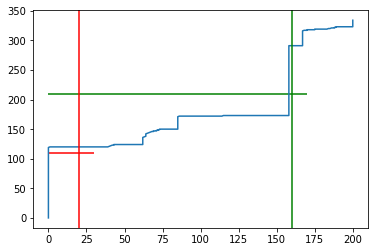

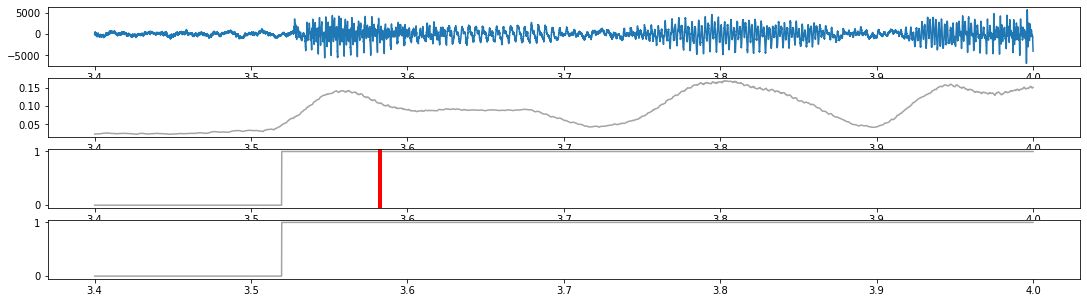

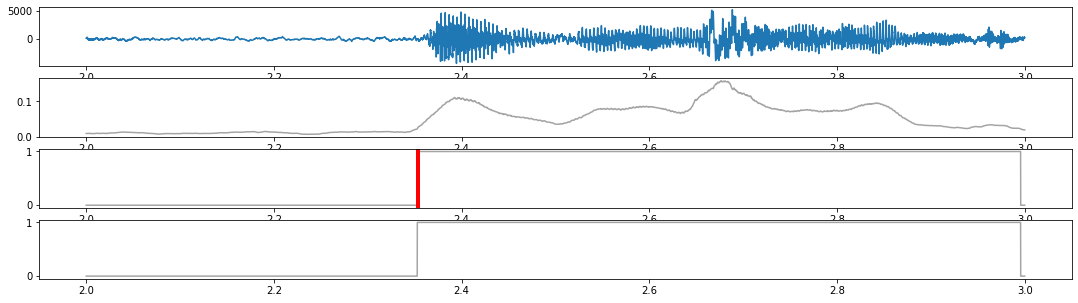

In [22]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 4
file2, seg2_1, seg2_2 = "01_1.wav", 2, 3

time1_lst = [3.46, 3.88]
time2_lst = [2.33, 2.63] 
#setup.play_samples(play_x, play_y, play_sr)

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

(30, 201)
(30, 335)
distance:  71564.1341063393
4800
[[960, 2646]]


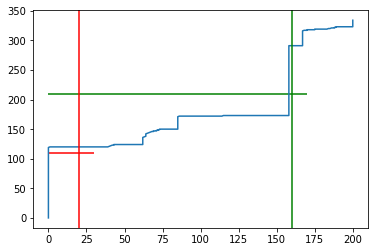

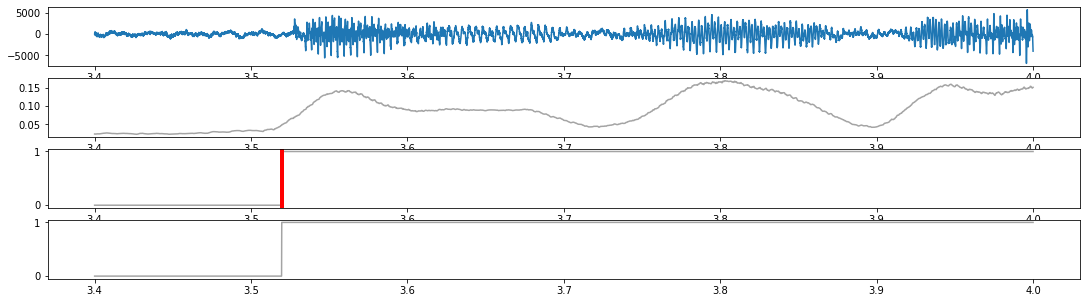

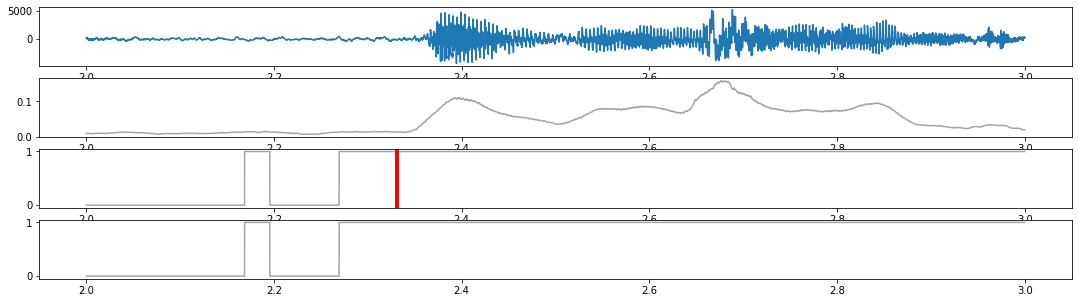

In [23]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 4
file2, seg2_1, seg2_2 = "01_1.wav", 2, 3

time1_lst = [3.46, 3.88]
time2_lst = [2.33, 2.63] 

output(input_min_amp1 = 500, input_min_amp2 = 150, input_min_pause = 30);

(30, 201)
(30, 335)
distance:  71564.1341063393
4800
[[1458, 2830]]


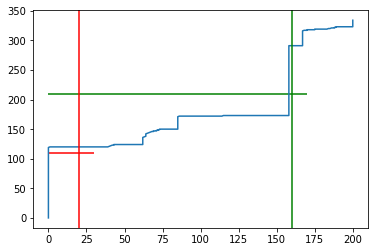

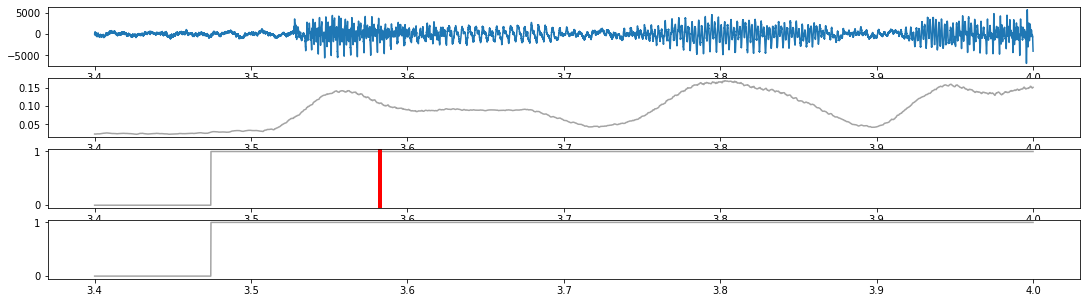

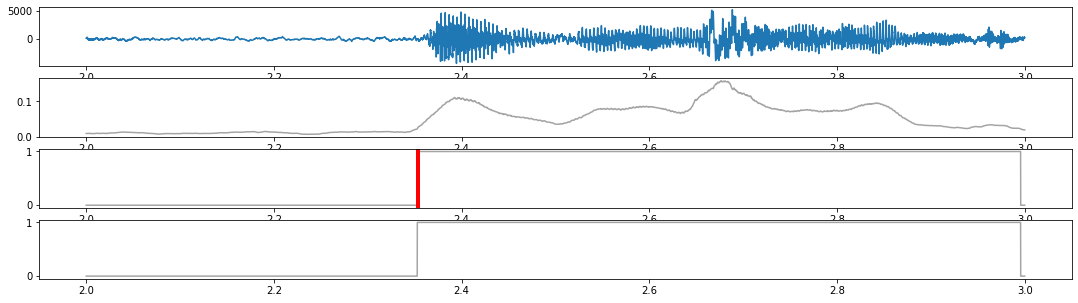

In [24]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 4
file2, seg2_1, seg2_2 = "01_1.wav", 2, 3

time1_lst = [3.46, 3.88]
time2_lst = [2.33, 2.63] 

output(input_min_amp1 = 300, input_min_amp2 = 250, input_min_pause = 30);

(30, 201)
(30, 335)
distance:  71564.1341063393
4800
[[600, 2200]]


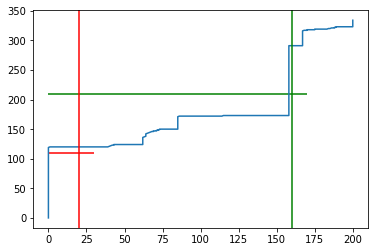

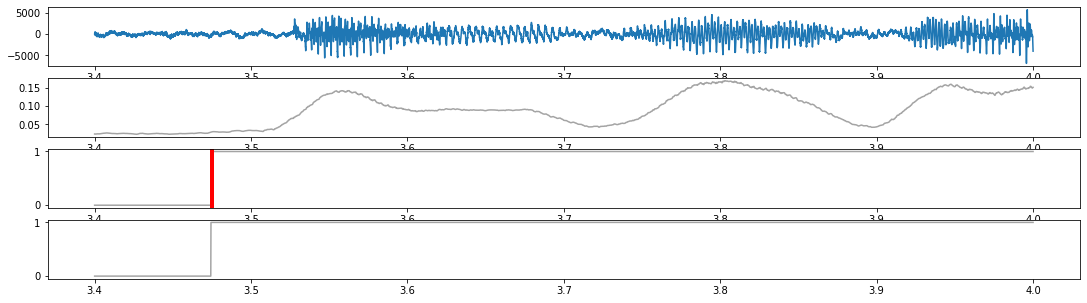

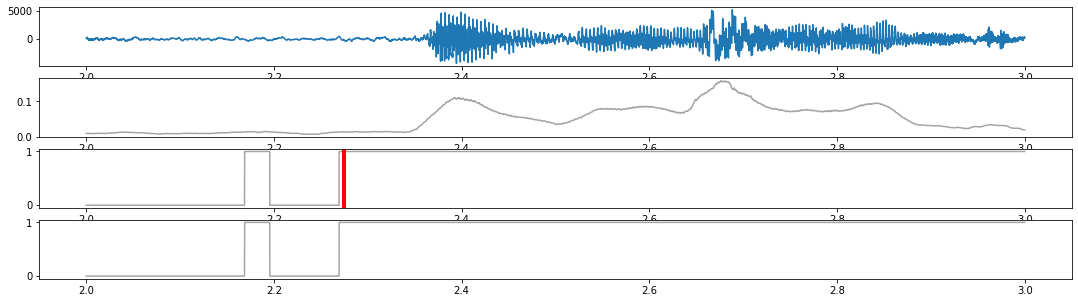

In [25]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 4
file2, seg2_1, seg2_2 = "01_1.wav", 2, 3

time1_lst = [3.46, 3.88]
time2_lst = [2.33, 2.63] 

output(input_min_amp1 = 300, input_min_amp2 = 150, input_min_pause = 30);

# Normal v.s. Normal 01 vs 01_1 Bamboo walls are getting to be very popular

(30, 869)
(30, 1003)
distance:  209963.6062769523
20800
[[2008, 2832], [6060, 6816], [6776, 7710], [7775, 8198], [8327, 9459]]


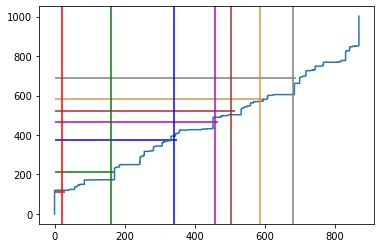

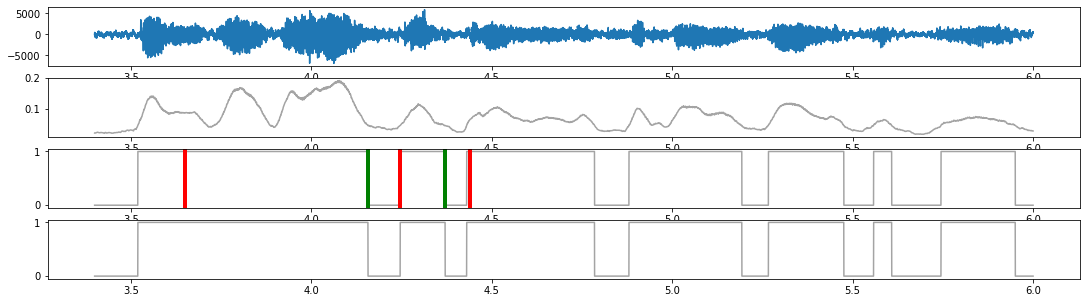

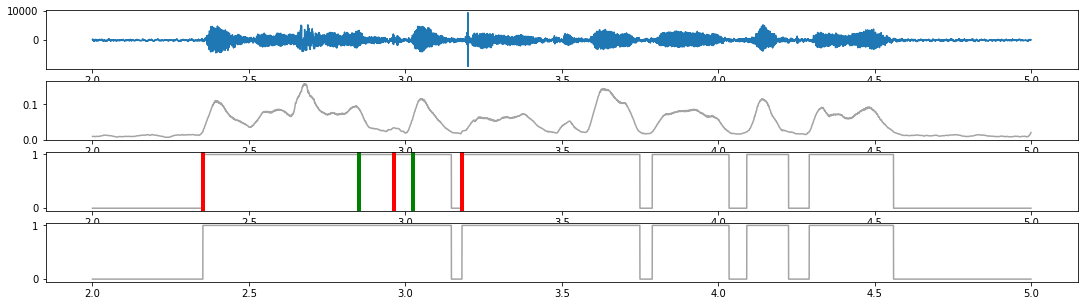

In [26]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo vs B B Bamboo 01 vs repeat-syllable01

(30, 201)
(30, 669)
distance:  124155.92019132282
4800
[]


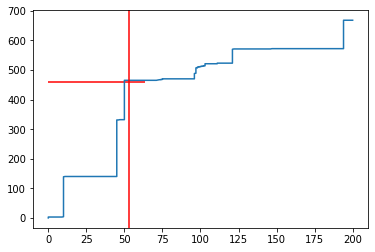

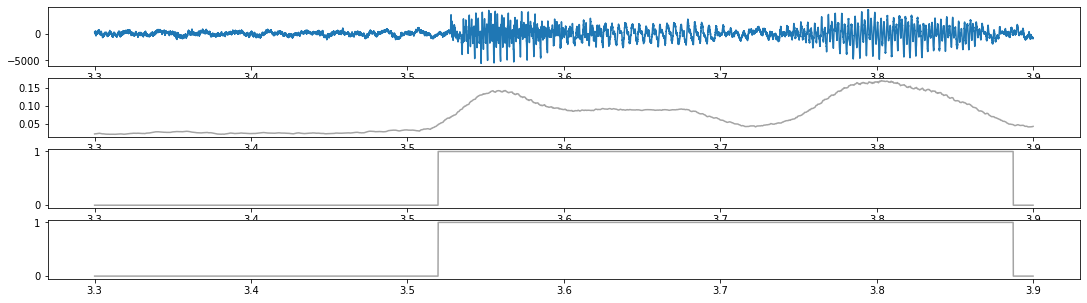

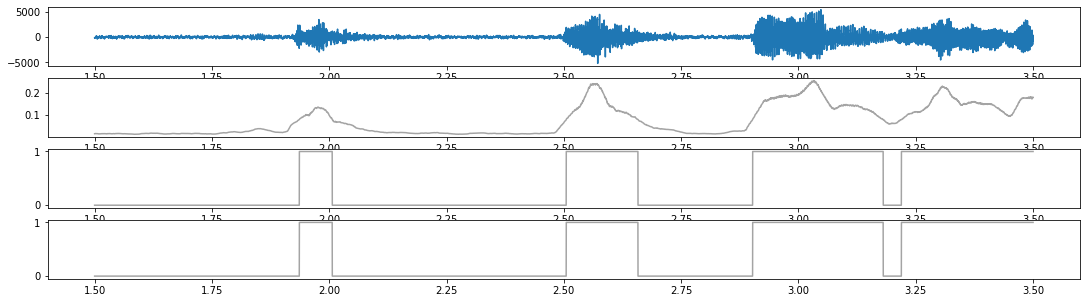

In [27]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 3.5

time1_lst = [3.46]
time2_lst = [2.88]
# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 530, input_min_pause = 30);

# Bamboo vs Bamboo: 01 vs test2

(30, 201)
(30, 669)
distance:  143137.69348939657
4800
[]


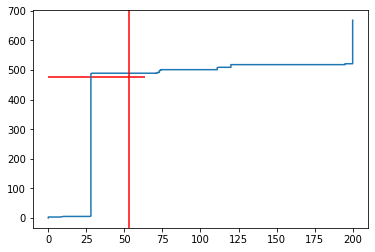

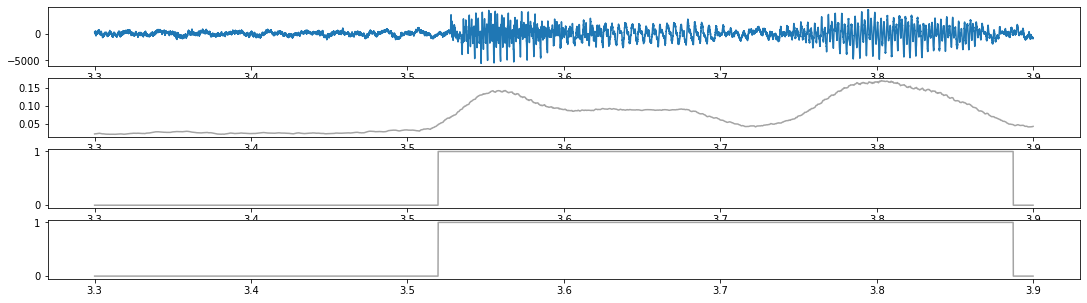

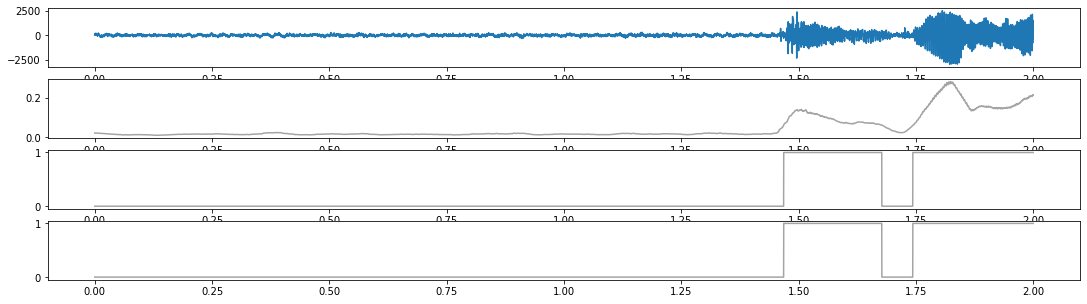

In [28]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "test2.wav", 0, 2

time1_lst = [3.46]
time2_lst = [1.43]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls are vs B B Bamboo walls are: 01 vs repeat-syllable01

(30, 301)
(30, 869)
distance:  154378.97923084896
7200
[[1762, 15564]]


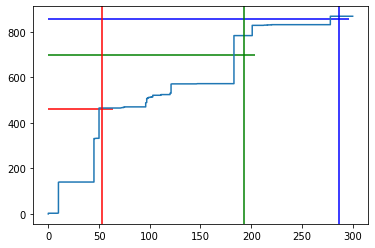

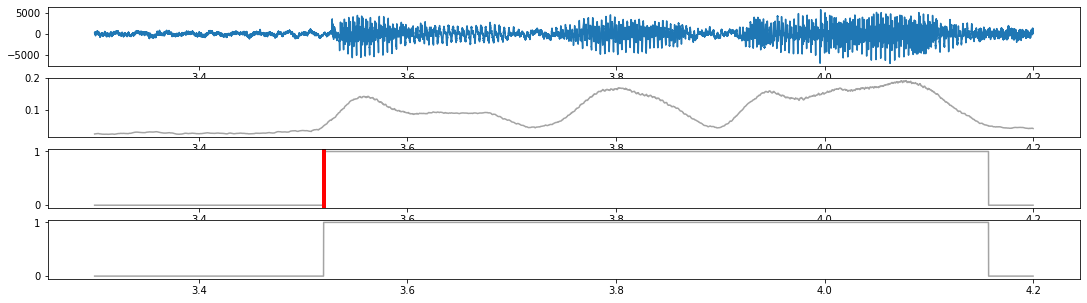

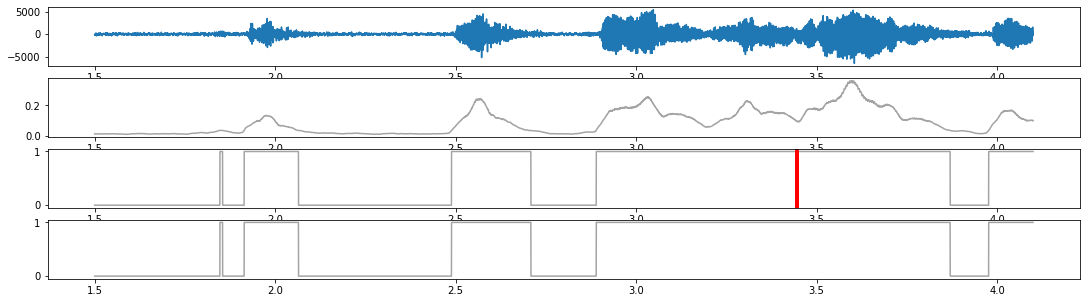

In [29]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 4.1

time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Test - Bamboo walls vs Bamboo + pause + walls test2 vs test1

(30, 1003)
(30, 1671)
distance:  122991.89165847302
24000
[]


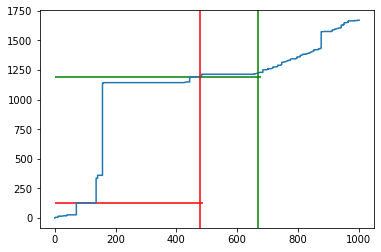

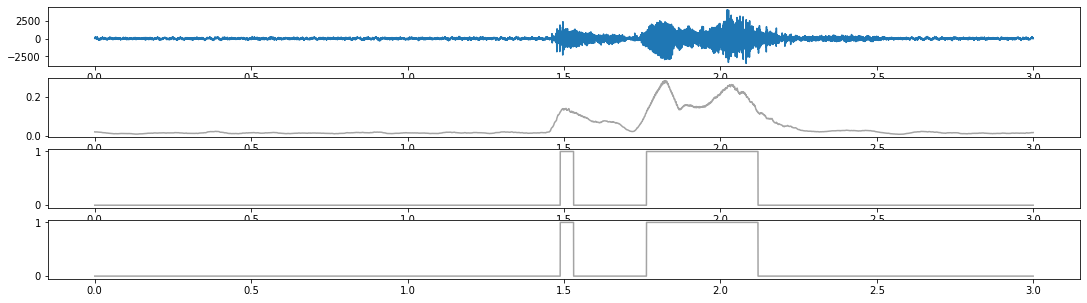

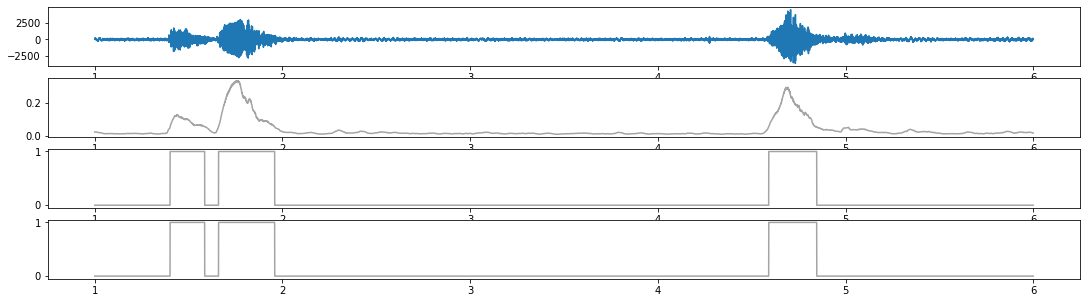

In [30]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test1.wav", 1, 6

time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Test - Bamboo walls test2 vs test3

(30, 1003)
(30, 1032)
distance:  135066.20392627054
24000
[]


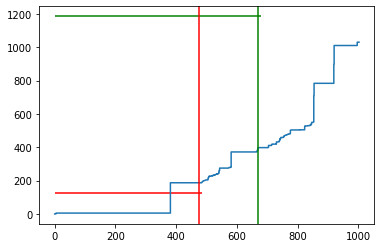

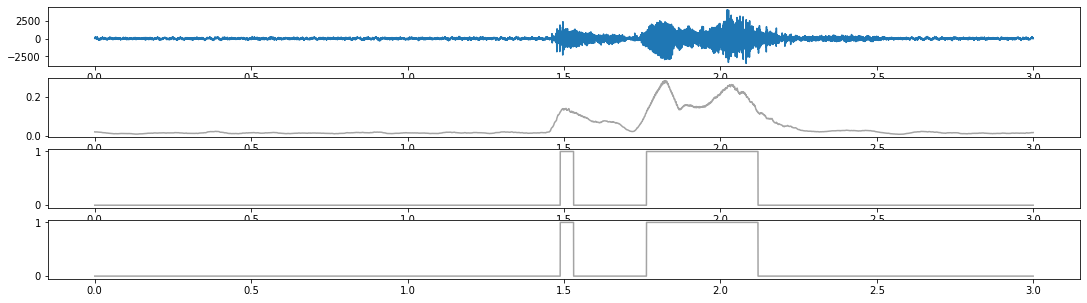

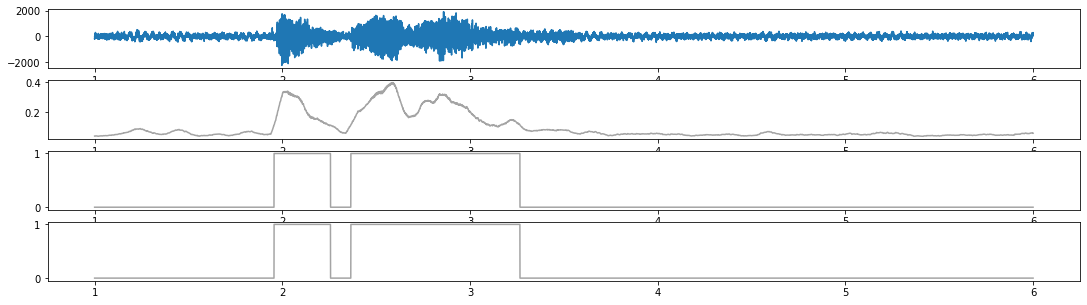

In [31]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test3.wav", 1, 6

time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls are getting vs B B Bamboo ~ : 01 vs repeat-syllable01

(30, 435)
(30, 969)
distance:  178805.59234141873
10400
[[1762, 13515]]


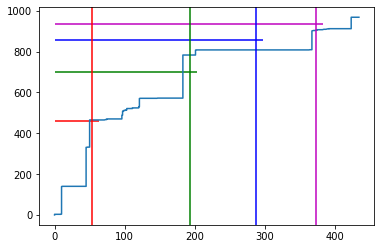

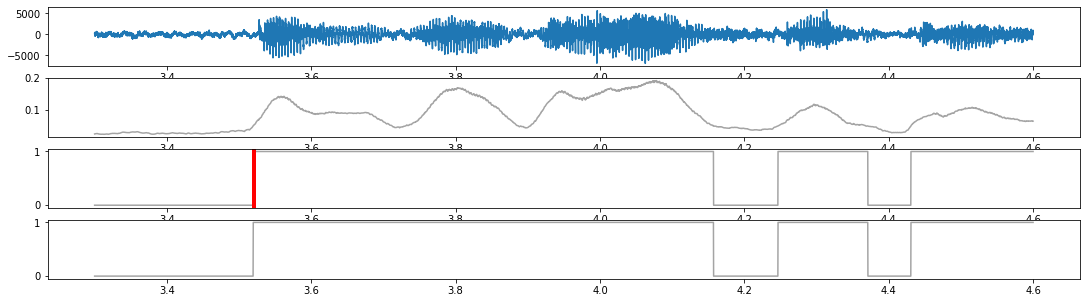

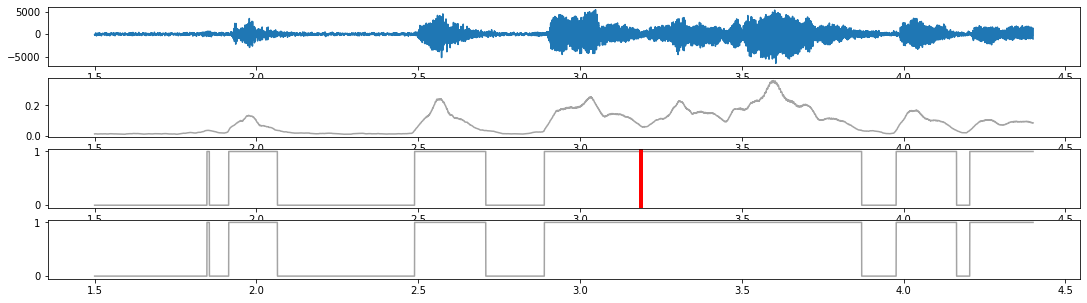

In [32]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 4.4

time1_lst = [3.46, 3.88, 4.16, 4.42]
time2_lst = [2.88, 3.6, 4.07, 4.3]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# without stuttering

# Bamboo walls are : 01 vs repeat-syllable01

(30, 301)
(30, 468)
distance:  92126.87291407354
7200
[[1762, 5629]]


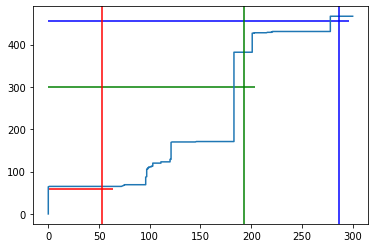

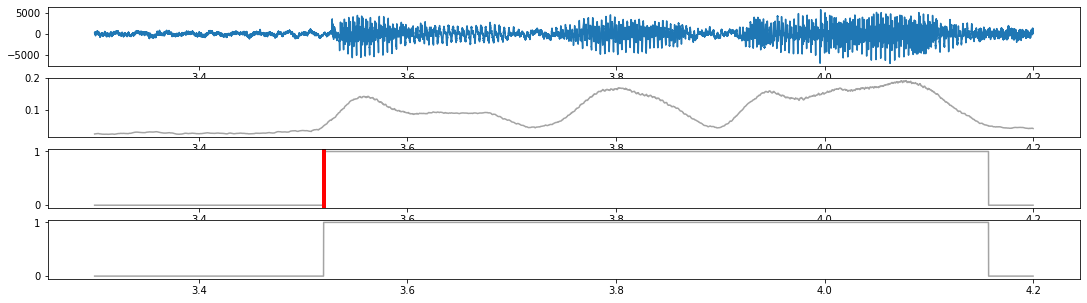

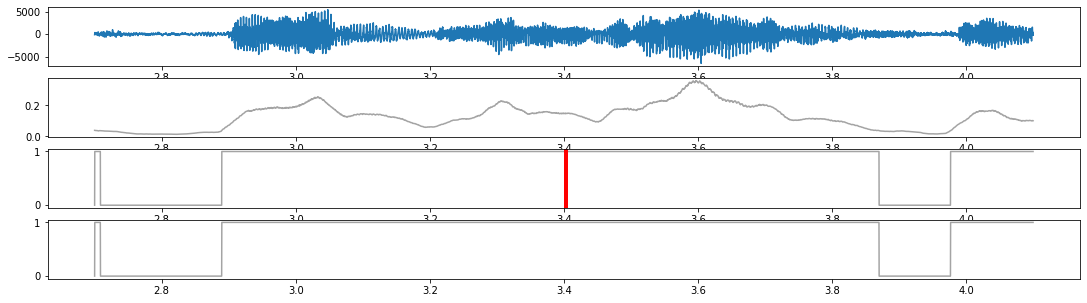

In [33]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.1

time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo vs Bamboo 01 vs repeat-syllable01

(30, 201)
(30, 268)
distance:  57914.2666908194
4800
[[1759, 2373]]


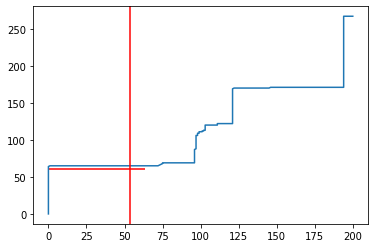

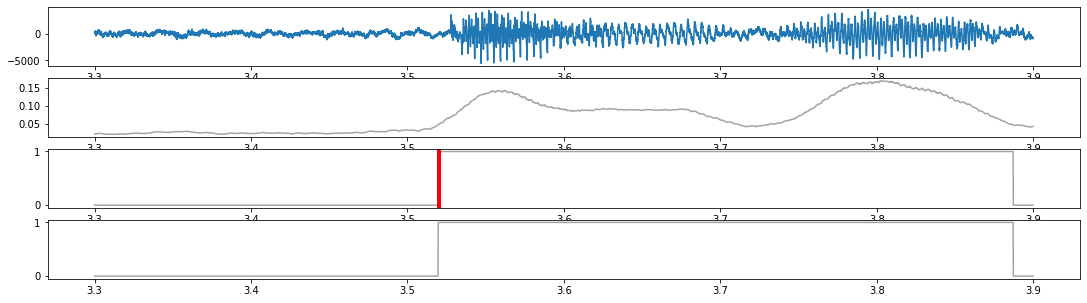

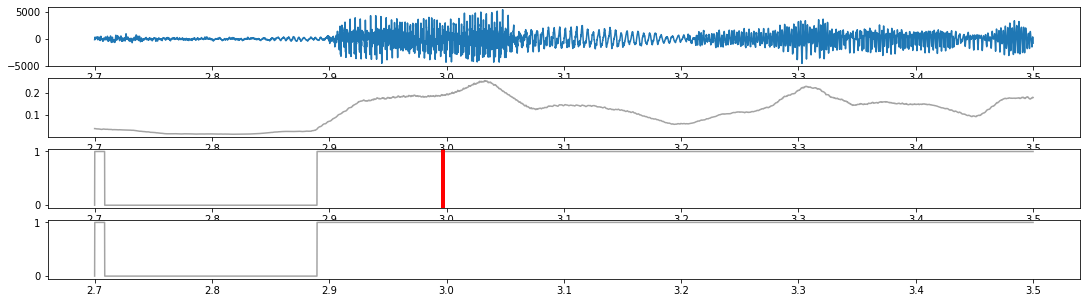

In [34]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 3.5

time1_lst = [3.46]
time2_lst = [2.88]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls vs Bamboo walls : 01 vs repeat-syllable01

(30, 268)
(30, 368)
distance:  75928.23548333962
6400
[[1757, 2431]]


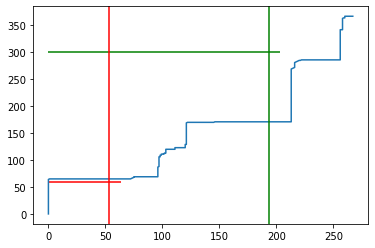

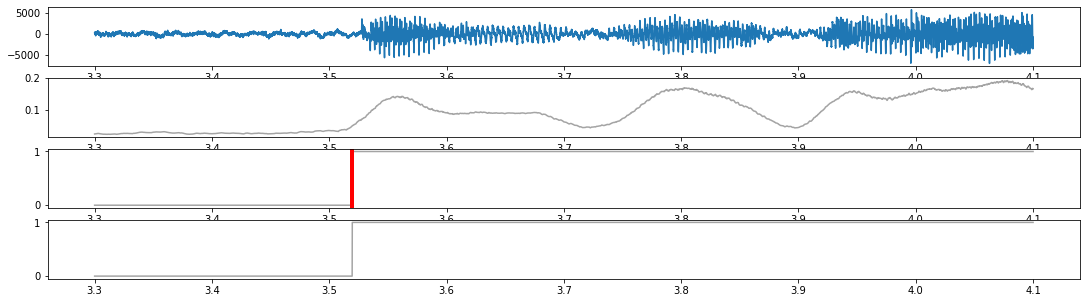

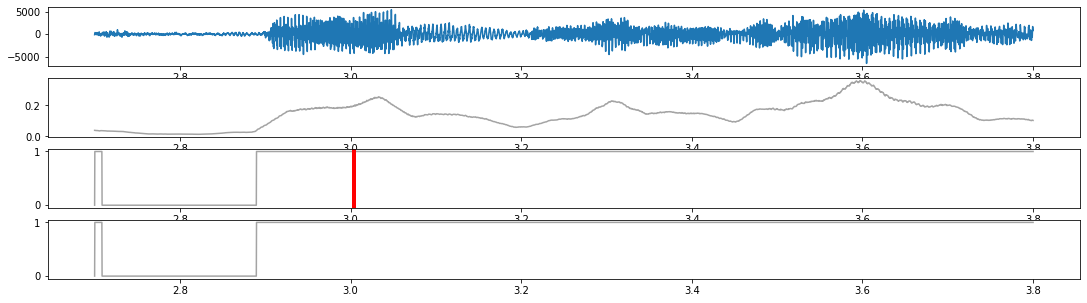

In [35]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.1
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 3.8

time1_lst = [3.46, 3.88]
time2_lst = [2.88, 3.6]
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls are : 01 vs repeat-syllable01

(30, 301)
(30, 468)
distance:  92126.87291407354
7200
[[1762, 5629]]


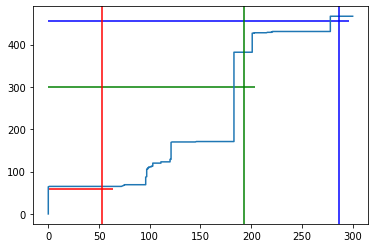

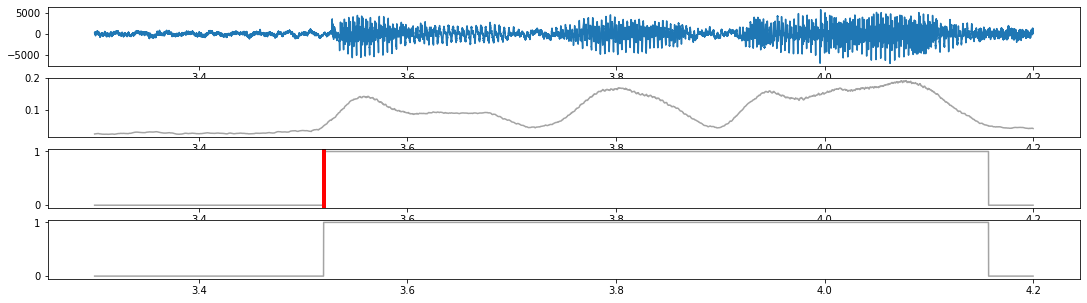

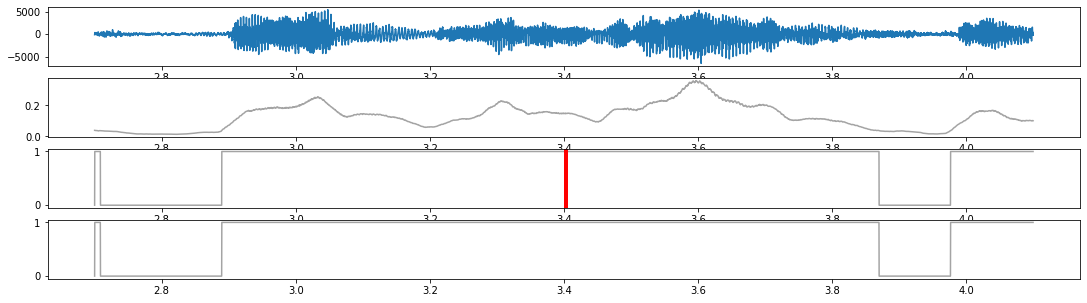

In [36]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.1

time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls are getting : 01 vs repeat-syllable01

(30, 435)
(30, 568)
distance:  116542.44551568868
10400
[[1766, 2351]]


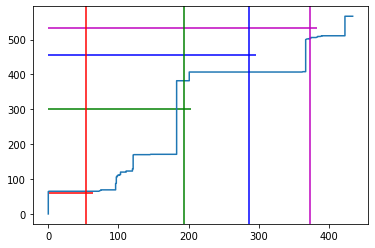

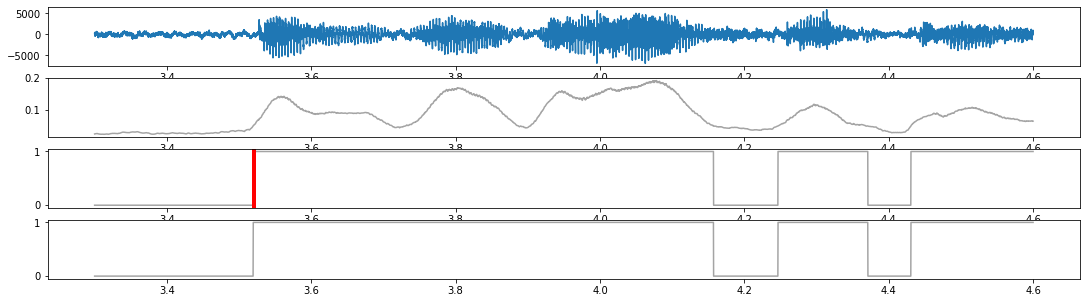

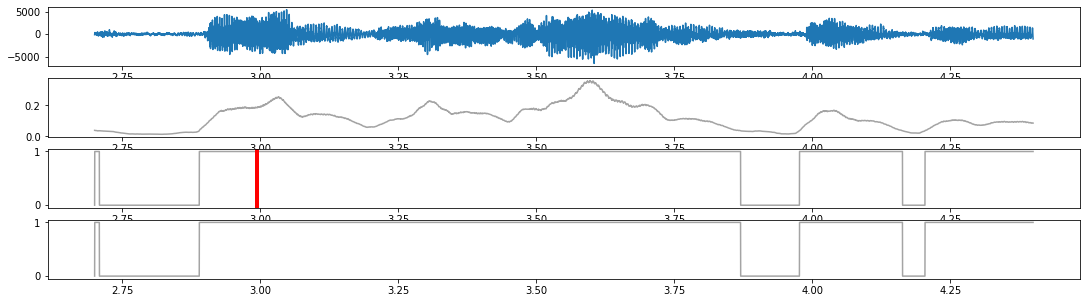

In [37]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.4

time1_lst = [3.46, 3.88, 4.16, 4.42]
time2_lst = [2.88, 3.6, 4.07, 4.3]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls are getting to be : 01 vs repeat-syllable01

(30, 568)
(30, 702)
distance:  140790.29206919865
13600
[[1760, 2281]]


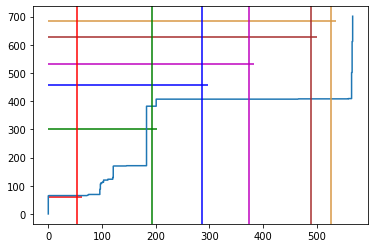

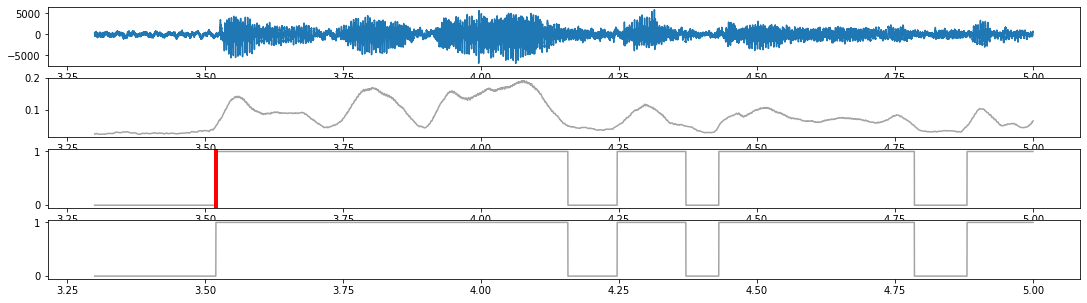

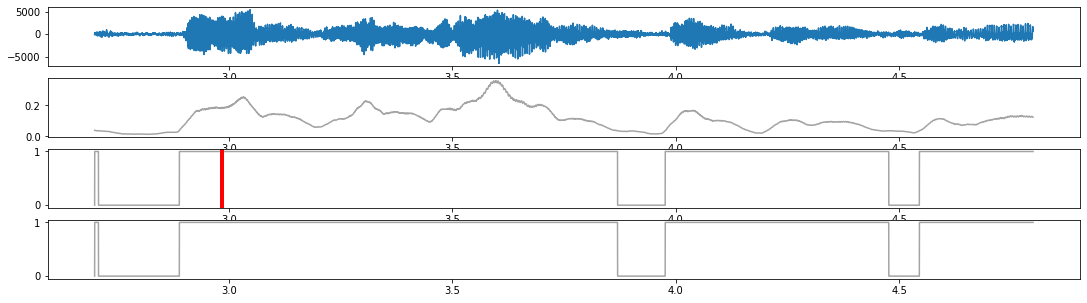

In [38]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.8

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88]
time2_lst = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 50);

# Bamboo walls are getting to be very popular  : 01 vs repeat-syllable01(po po popular)

(30, 903)
(30, 1303)
distance:  244853.9012851688
21600
[[1761, 2457], [6865, 6165], [7581, 12919], [7760, 14227], [7760, 14773], [8576, 18711]]


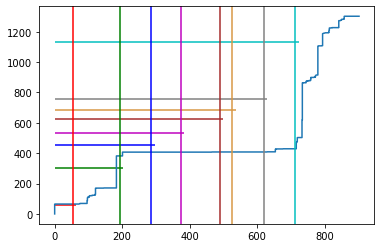

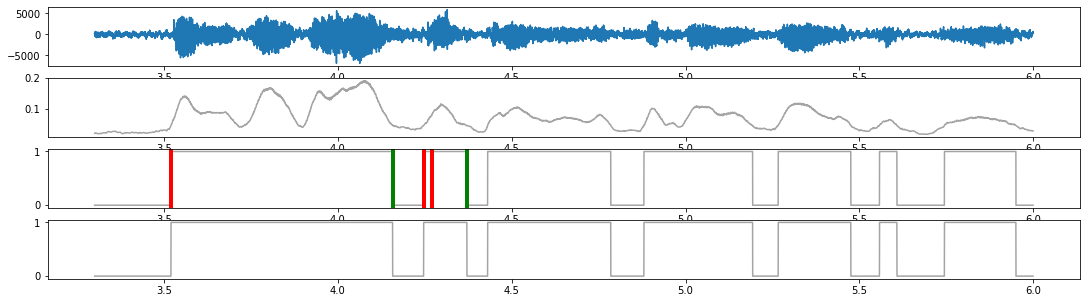

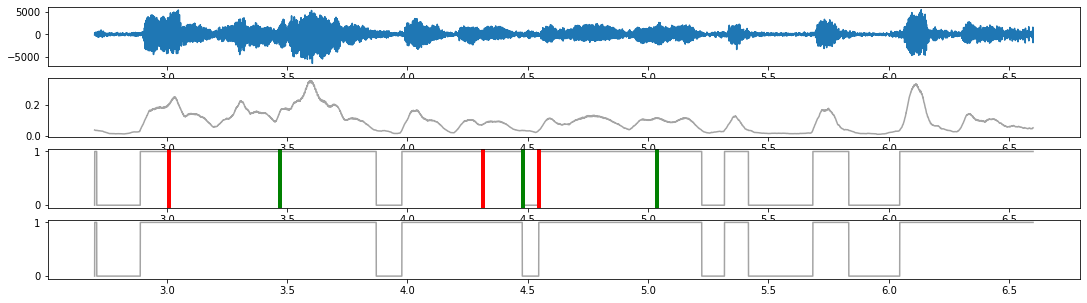

In [39]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 6.6

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44]
time2_lst = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75, 4.98, 6.10]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 50);

(30, 869)
(30, 1003)
distance:  209963.6062769523
Default amplitude threshold:  629
Default amplitude threshold:  126
20800
[[998, 2073], [2407, 3387], [2760, 3387], [5978, 6816], [6870, 7738], [7528, 8198], [8291, 9418]]


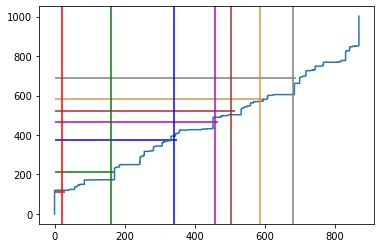

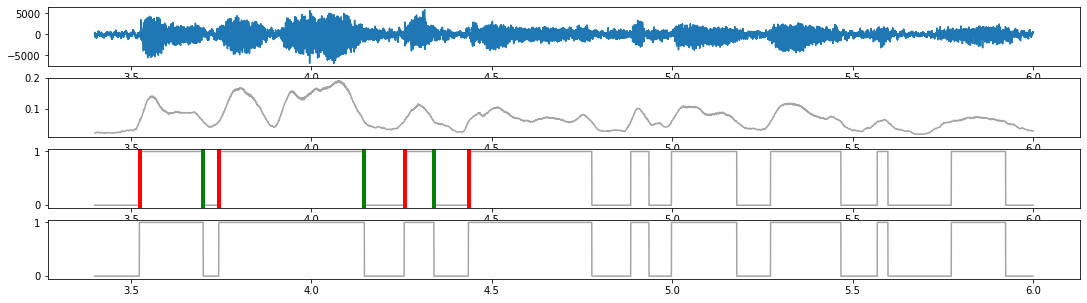

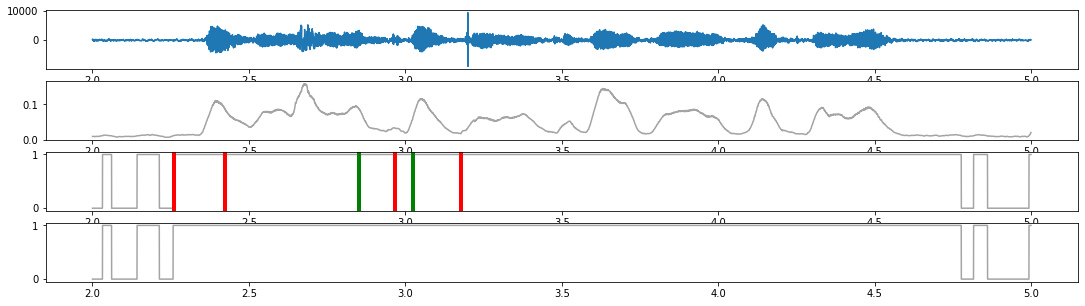

In [40]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

output(input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs 01_2

(30, 869)
(30, 1003)
distance:  269737.0946279203
20800
[[5186, 2195], [5186, 3479], [5186, 3967], [6065, 4314], [6777, 4314], [7768, 4314], [8246, 4314], [9659, 7332], [9659, 8089], [9659, 9104], [9659, 9926], [9659, 11402], [9659, 12481], [9659, 12853]]


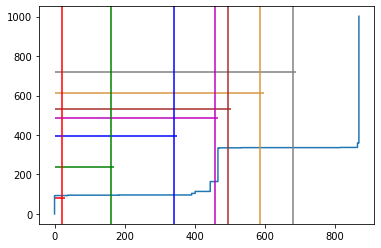

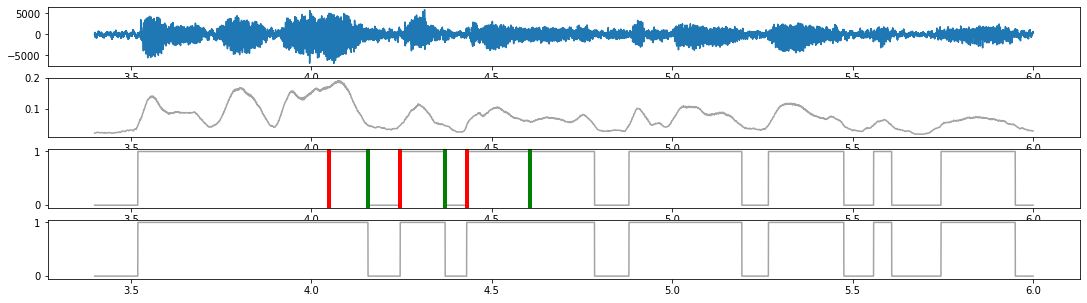

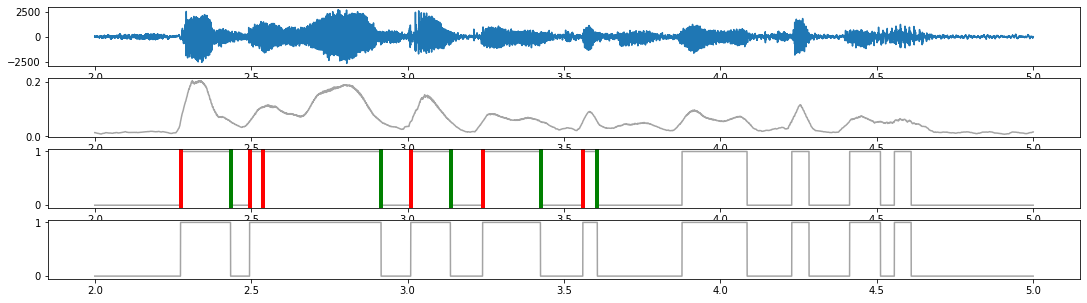

In [41]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5

time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs 01_3

(30, 869)
(30, 903)
distance:  138741.83630775393
20800
[[965, 937], [6059, 5823], [6774, 6383], [7778, 7061], [8254, 7321]]


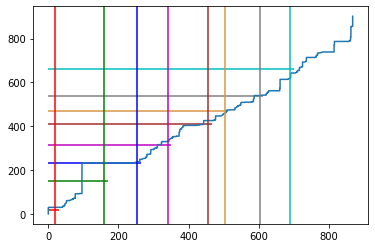

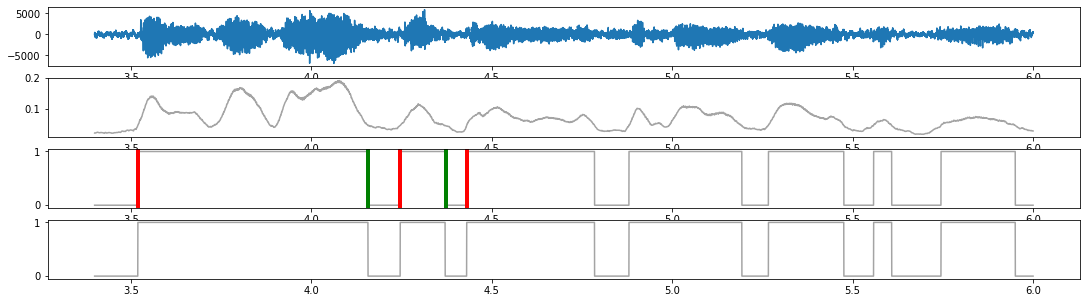

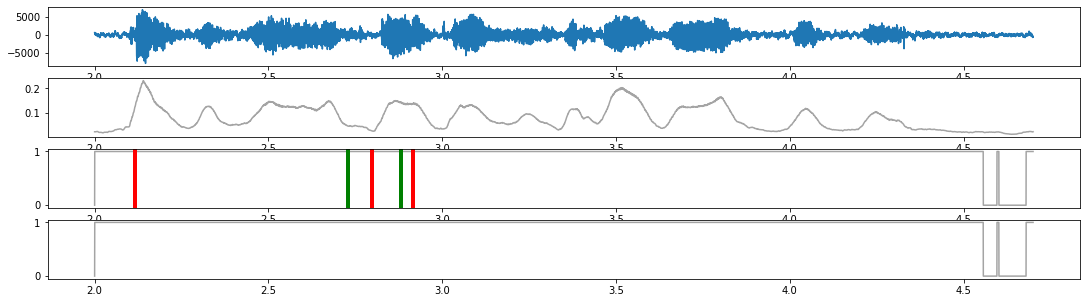

In [42]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs 01_3

(30, 869)
(30, 903)
distance:  138741.83630775393
Default amplitude threshold:  629
Default amplitude threshold:  824
20800
[[991, 1198], [1204, 1823], [1204, 2397], [1204, 2879], [3663, 3595], [5984, 5588], [6887, 6605], [7527, 7034], [8292, 7464], [8292, 7673], [8668, 8181], [9233, 9093], [10224, 9770], [10236, 10200], [10826, 10852]]


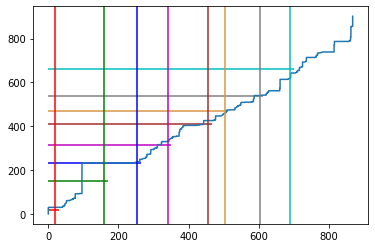

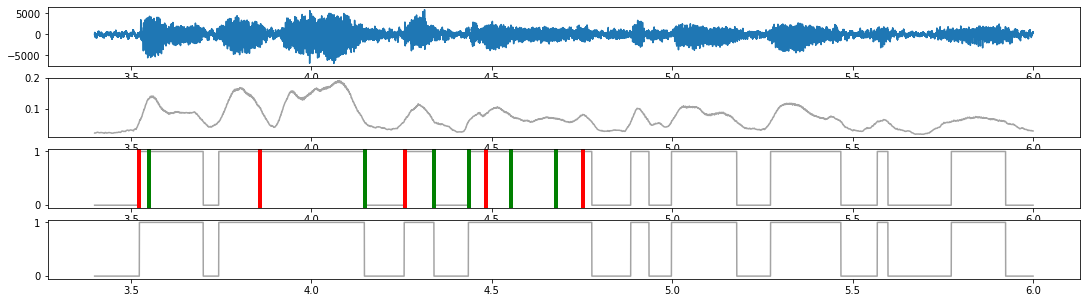

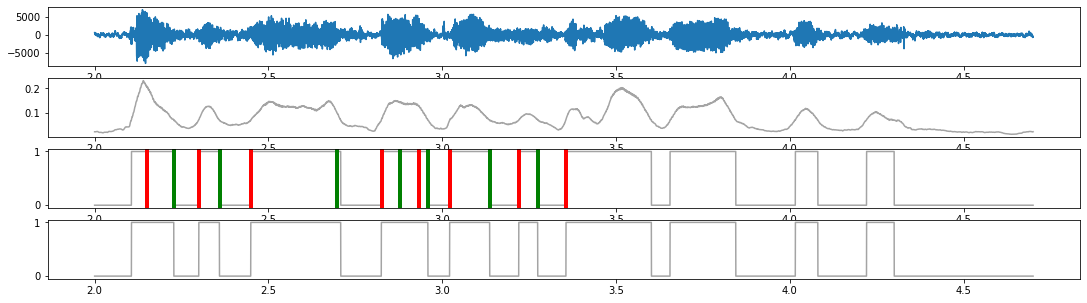

In [43]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs 01_3

(30, 869)
(30, 903)
distance:  138741.83630775393
20800
[[965, 937], [6059, 5823], [6874, 6500], [7778, 7061], [8254, 7321], [8292, 7816], [8668, 8116]]


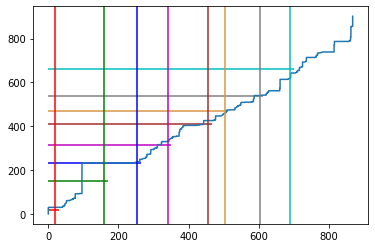

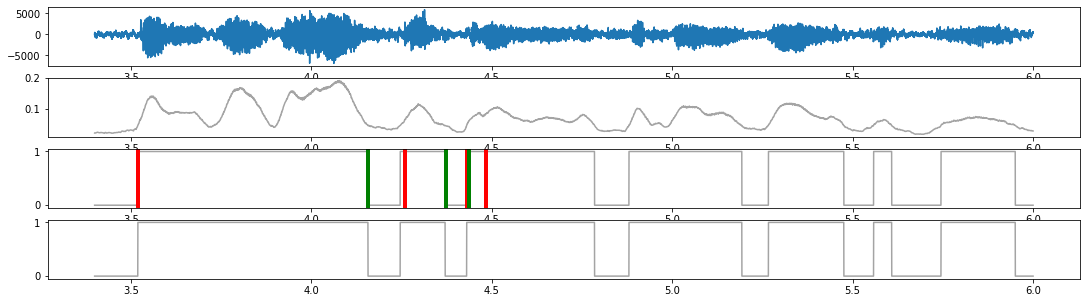

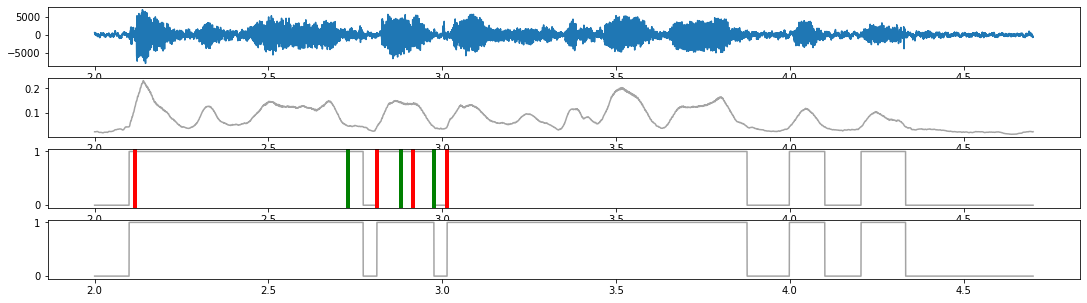

In [44]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 500, input_min_amp2 = 500, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs 01_3

(30, 869)
(30, 903)
distance:  138741.83630775393
20800
[[12, 390]]


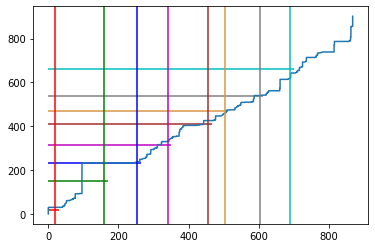

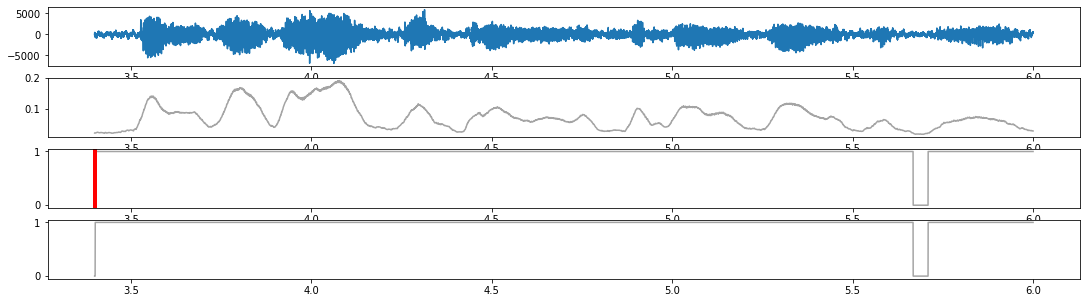

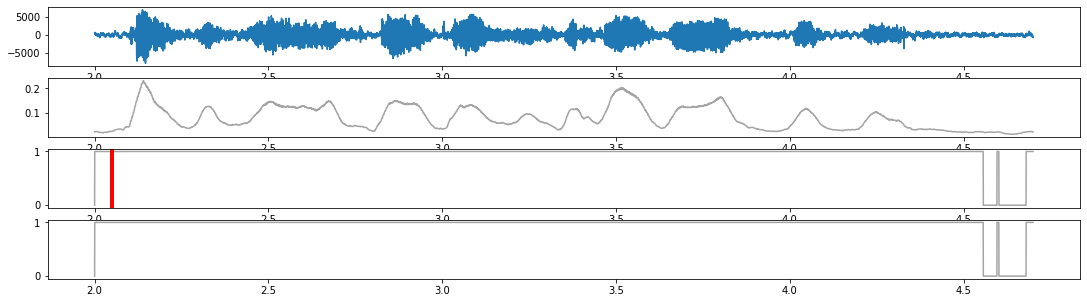

In [45]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 250, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs 01_3

(30, 1003)
(30, 903)
distance:  161055.44065812515
Default amplitude threshold:  126
Default amplitude threshold:  824
24000
[[2068, 900], [3109, 1825], [3515, 2397], [3961, 2884], [4867, 3602], [6841, 5670], [8139, 6607], [9437, 7678], [9694, 8177], [10424, 9102], [11506, 9771], [11520, 10197], [11547, 10854]]


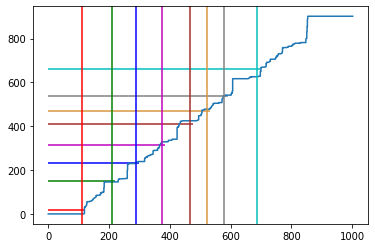

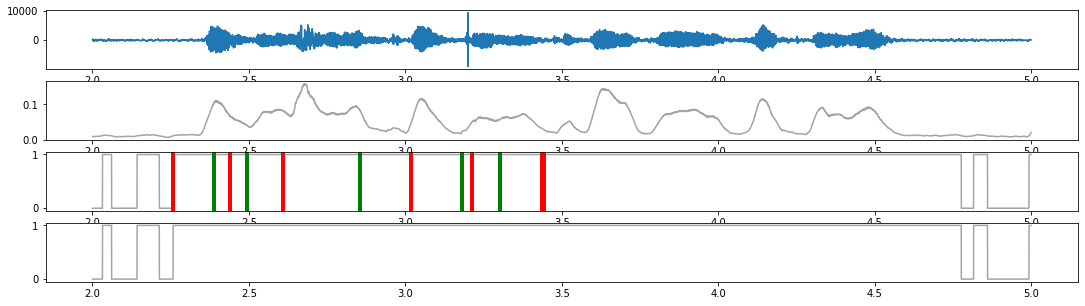

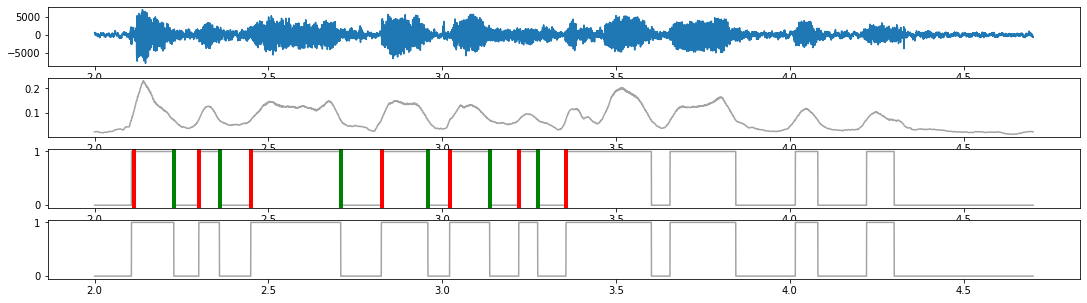

In [46]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs 01_3

(30, 1003)
(30, 903)
distance:  161055.44065812515
24000
[[2907, 1776], [7017, 5816], [8139, 6595], [8937, 7532], [9681, 8165], [11344, 9516], [12087, 10976], [12263, 10976], [12736, 10976]]


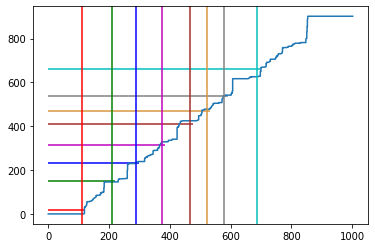

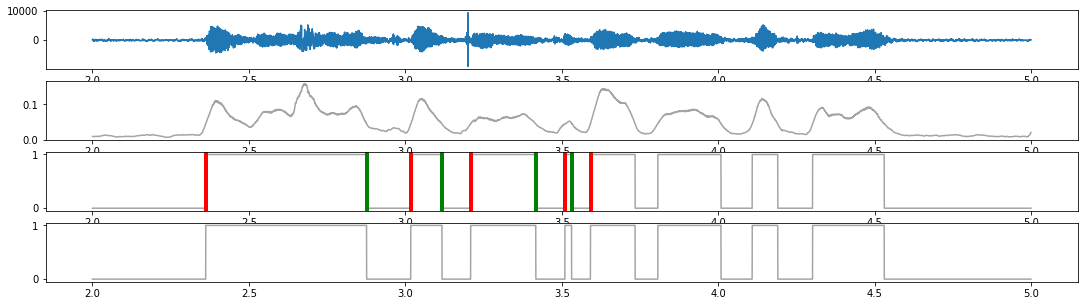

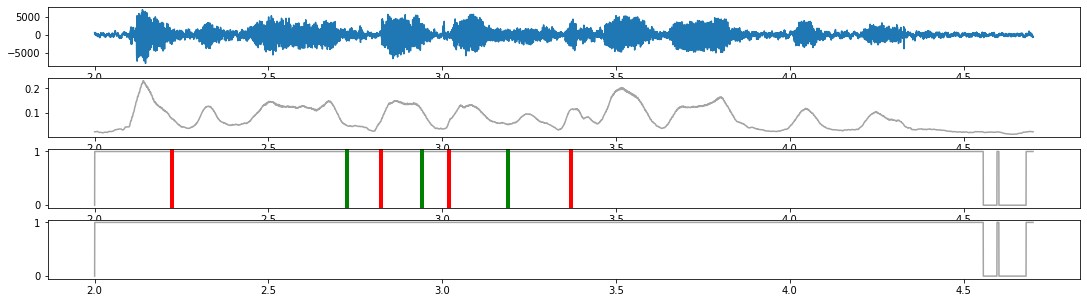

In [47]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs 01_3

(30, 1003)
(30, 903)
distance:  161055.44065812515
24000
[[2907, 1776], [7017, 5816], [8139, 6595], [8937, 7532], [9681, 8165], [11344, 9516], [12087, 10976], [12263, 10976], [12736, 10976]]


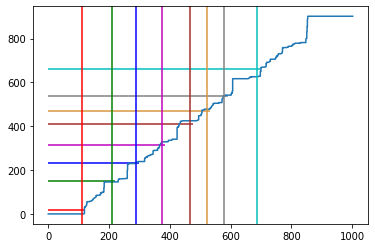

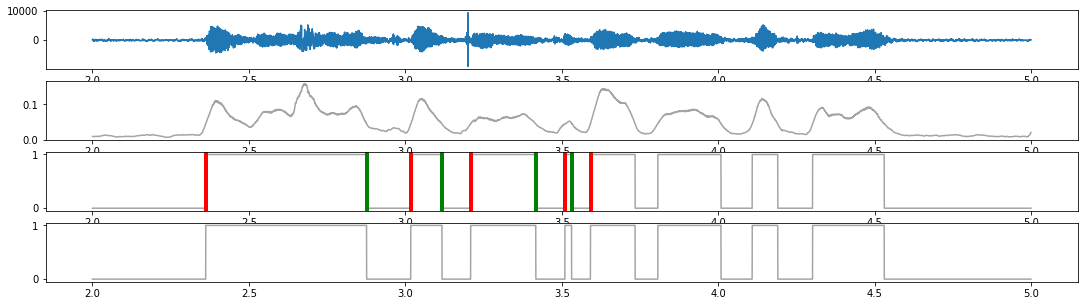

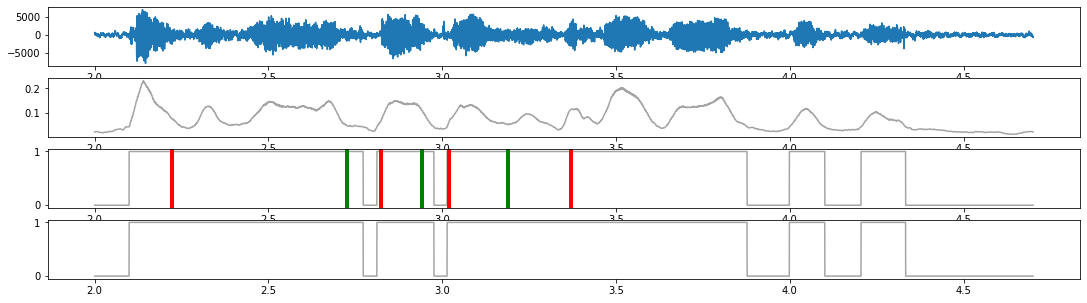

In [48]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 500, input_min_amp2 = 500, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_2 vs 01_3

(30, 1003)
(30, 903)
distance:  227702.65176377012
24000
[[2284, 9640], [3020, 9640], [4340, 9640], [4632, 9640], [5508, 9640], [6993, 9640], [8274, 9640], [8782, 9640]]


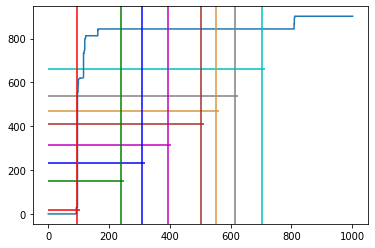

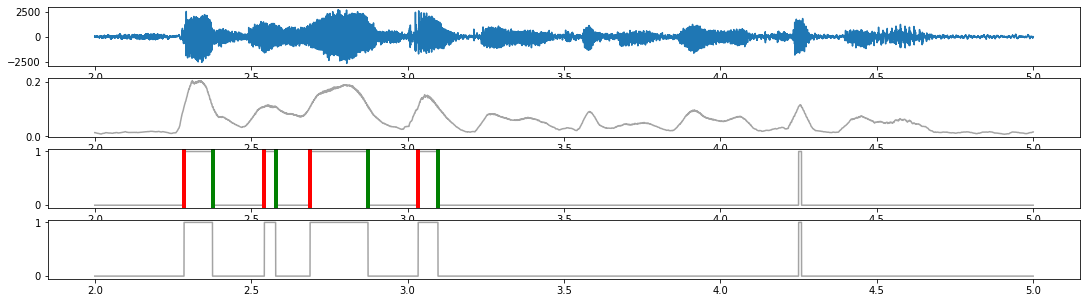

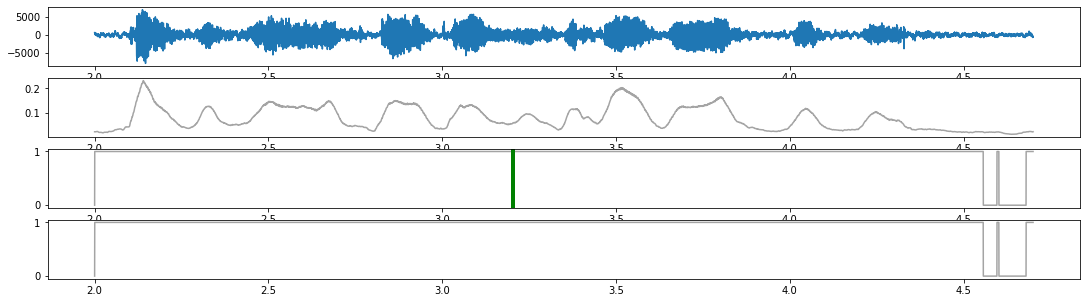

In [49]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs 01_2

(30, 1003)
(30, 1003)
distance:  185681.98498663888
24000
[[2897, 4225], [6654, 7325], [8147, 8084], [8944, 9058], [9678, 10855], [11348, 11247], [12082, 11361], [12082, 11399]]


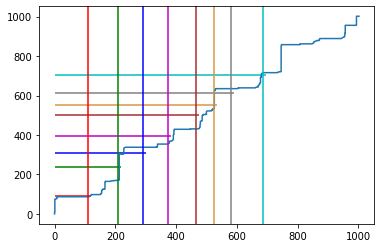

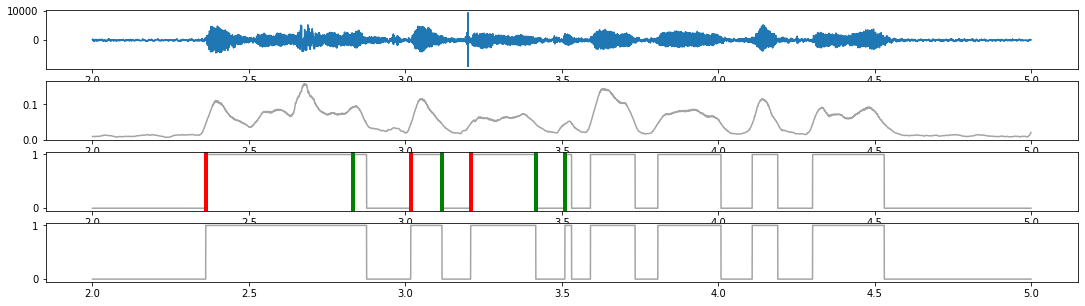

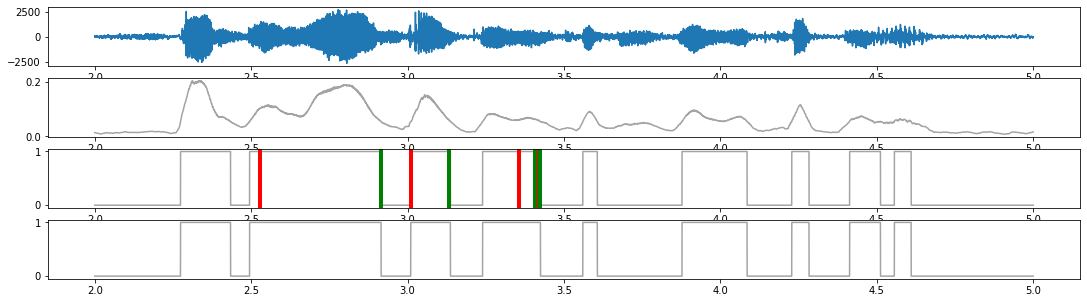

In [50]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_3 vs 01_2

(30, 903)
(30, 1003)
distance:  227702.65176377012
21600
[[9640, 2195], [9640, 3477], [9640, 3959], [9640, 7323], [9640, 8084], [9640, 9099], [9640, 9924], [10303, 11409], [10303, 12488]]


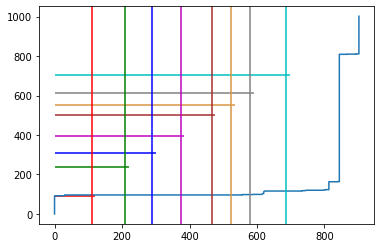

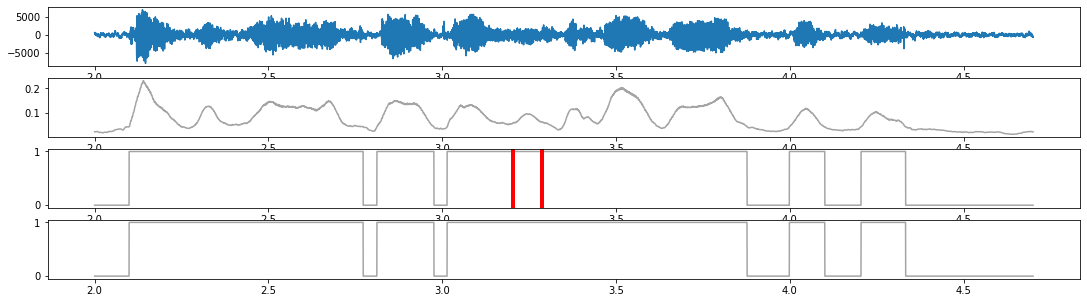

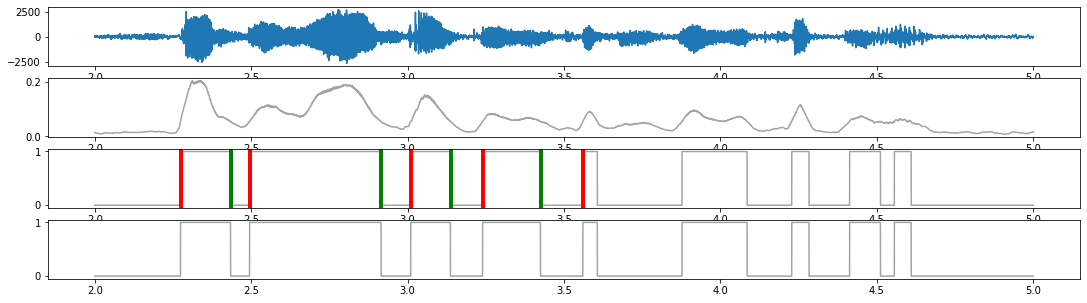

In [51]:
file1, seg1_1, seg1_2 = "01_3.wav", 2, 4.7
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - normal vs slightly slow: 01 vs 02: Bamboo walls are getting to be very popular

(30, 869)
(30, 1103)
distance:  170084.7593108576
20800
[[958, 1090], [6059, 9927], [6775, 11885], [7777, 13479], [8251, 14402]]


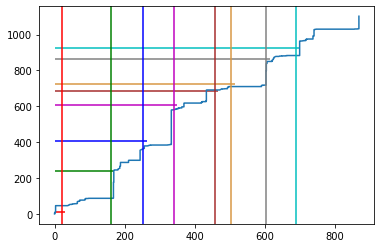

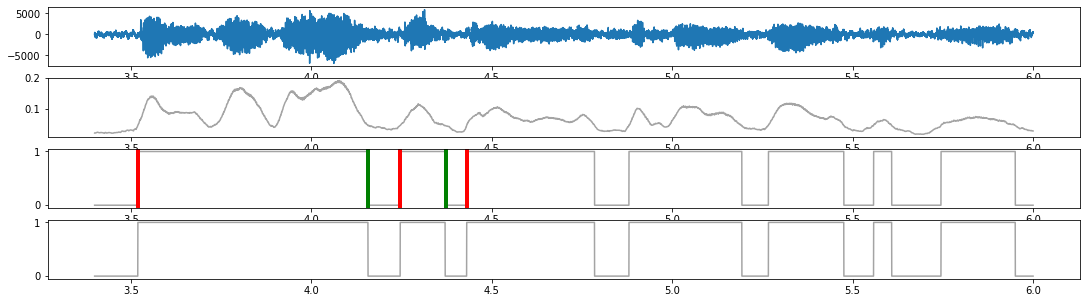

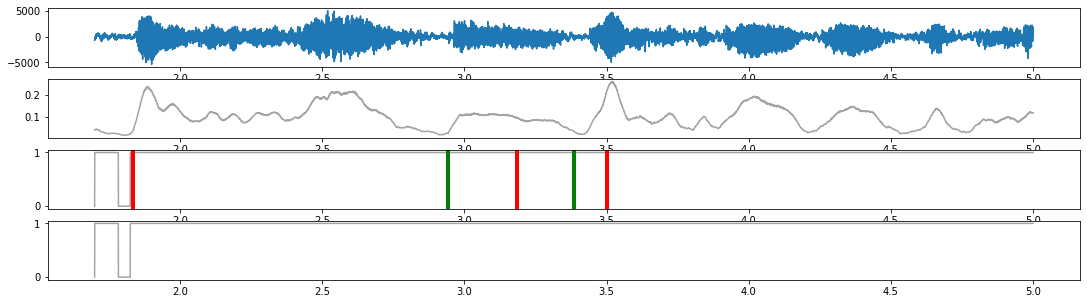

In [52]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]

output(input_min_amp1 = 500, input_min_amp2 = 230, input_min_pause = 30);

# Normal vs short pauses: 01 vs 05: Bamboo walls are getting to be very popular

(30, 869)
(30, 1537)
distance:  259354.82676975665
20800
[[963, 1010], [2989, 8225], [3016, 9125], [3114, 9267], [4408, 10861], [4425, 10987], [4648, 11272], [6058, 18297], [6772, 19355], [7022, 20728], [7745, 22023], [7745, 23507], [7745, 24075], [7745, 24233]]


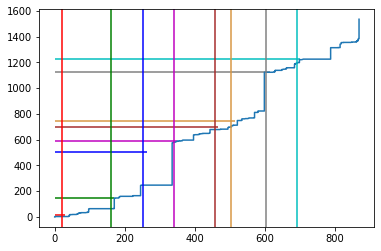

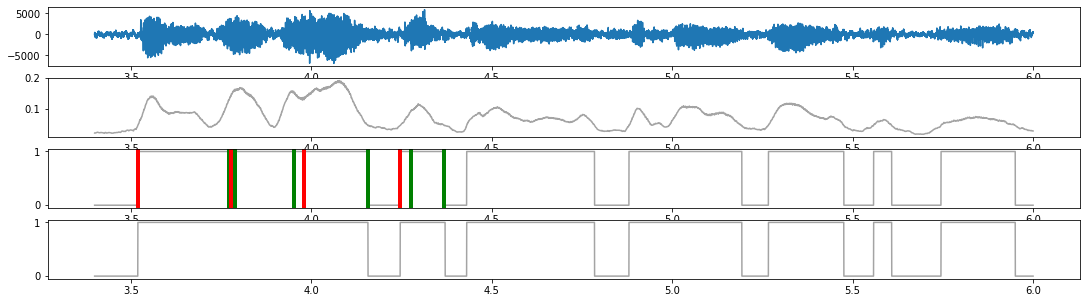

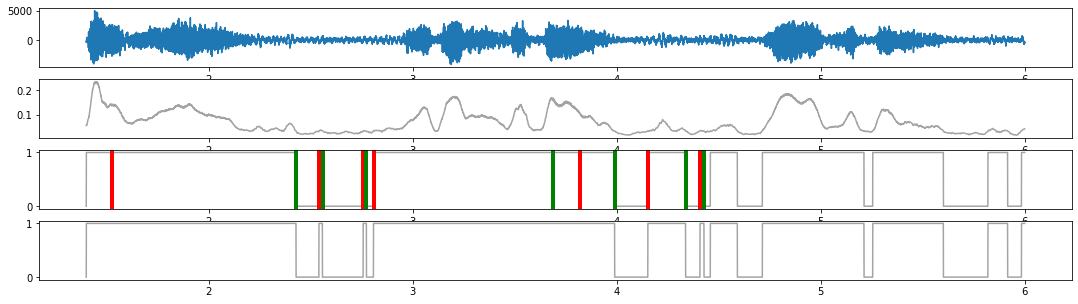

In [53]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "05.wav", 1.4, 6

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - normal vs repeat part of word + pauses: 01 vs pause_m01: Bamboo walls are getting to be very popular

(30, 869)
(30, 3843)
distance:  689134.4500261403
20800
[[961, 1058], [3331, 6662], [3331, 7269], [3331, 15029], [3331, 15637], [3331, 17870], [3331, 18204], [3331, 18458], [3331, 18733], [3331, 19712], [3331, 20026], [3331, 20751], [3331, 21202], [3331, 22710], [3331, 23494], [3331, 34585], [3331, 35291], [3331, 35761], [3331, 36035], [3331, 37446], [3331, 38073], [3331, 41914], [3331, 42345], [3331, 42521], [3331, 43090], [3331, 45128], [3331, 45519], [3331, 46186], [3331, 46578], [3331, 47381], [3331, 47832], [3823, 54847], [3841, 55258], [3845, 56591], [3845, 56865]]


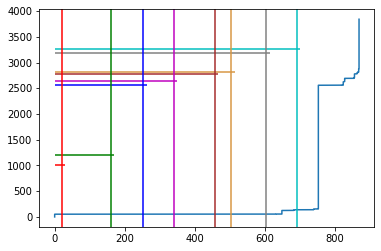

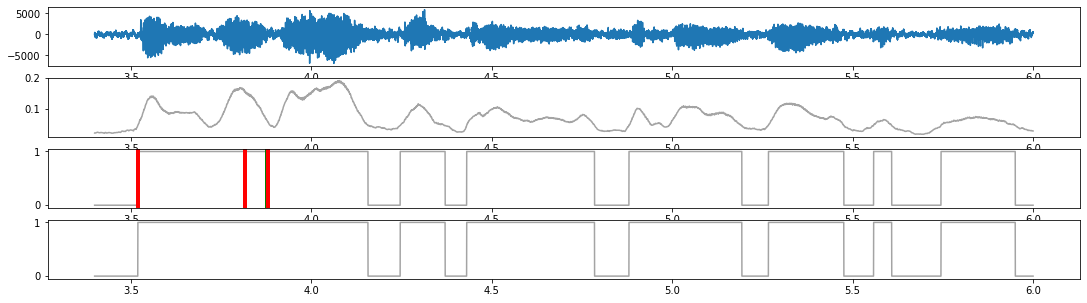

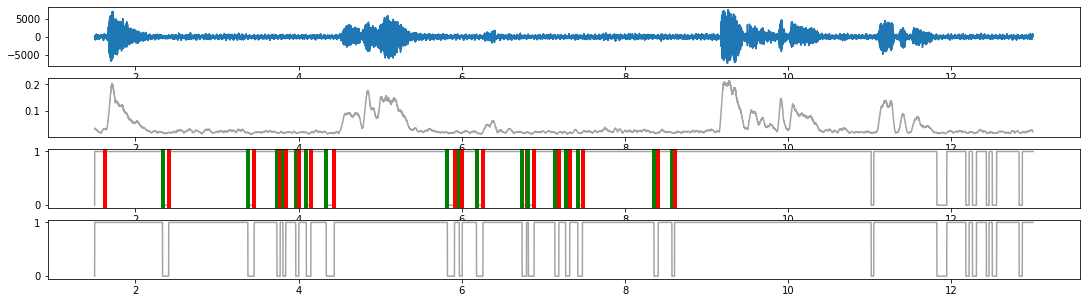

In [54]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "pause_m01.wav", 1.5, 13

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [4.52, 5.11, 9.18, 9.45, 9.82, 9.95, 11.06, 11.30]

output(input_min_amp1 = 500, input_min_amp2 = 230, input_min_pause = 30);

# Normal vs Stutter 01_1 vs repeat-syllable01: Bamboo walls are getting to be very popular

(30, 836)
(30, 2005)
distance:  226833.21127654606
20000
[[2899, 18843], [4253, 22975], [4863, 23823], [5077, 25324], [5261, 25642], [5401, 27832], [5401, 28379], [5489, 33783], [5489, 34543], [5489, 35337]]


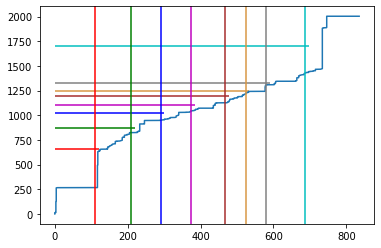

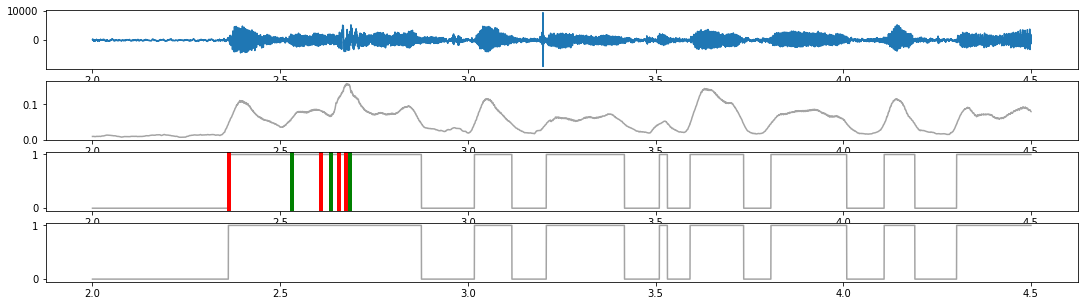

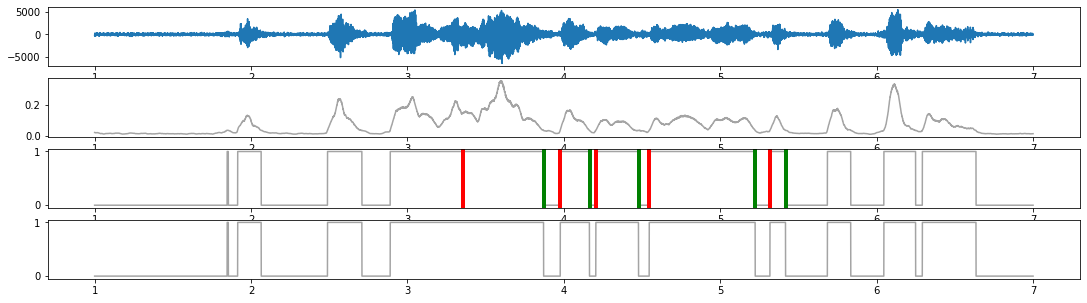

In [55]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Stutter 01_2 vs repeat-syllable01: Bamboo walls are getting to be very popular

(30, 836)
(30, 2005)
distance:  241055.382408378
20000
[[2241, 16576], [3107, 19598], [4097, 22602], [4599, 22969], [4672, 23825], [5036, 24820], [5385, 29135], [5967, 33799], [5967, 34550]]


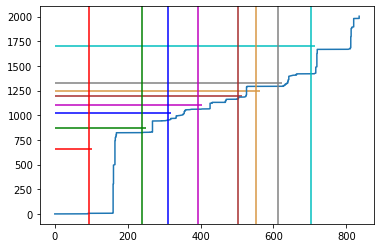

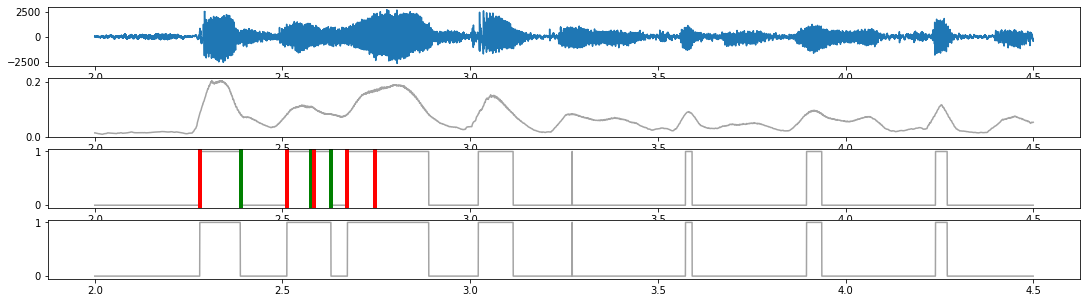

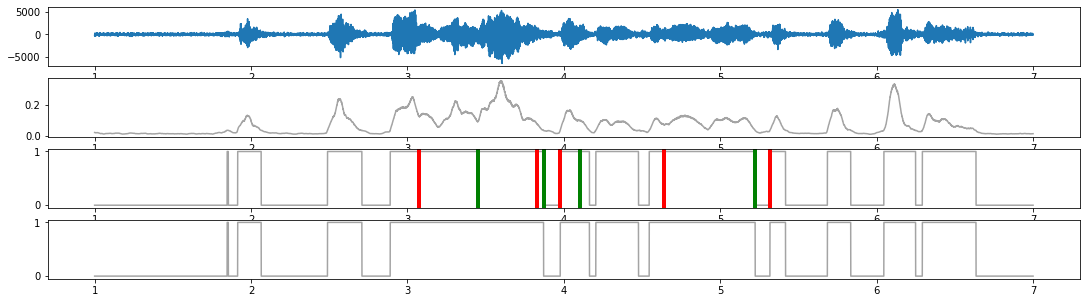

In [56]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

output(input_min_amp1 = 380, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01 vs 02_1: Bamboo walls are getting to be very popular

(30, 869)
(30, 1504)
distance:  374603.32118979486
20800
[[4094, 6479], [4094, 7878], [4094, 8167], [4094, 15133], [7627, 16866], [7627, 18600], [7627, 19498], [7627, 20319], [7627, 20988], [7627, 21931]]


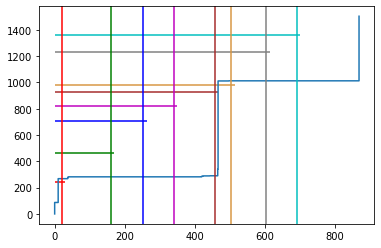

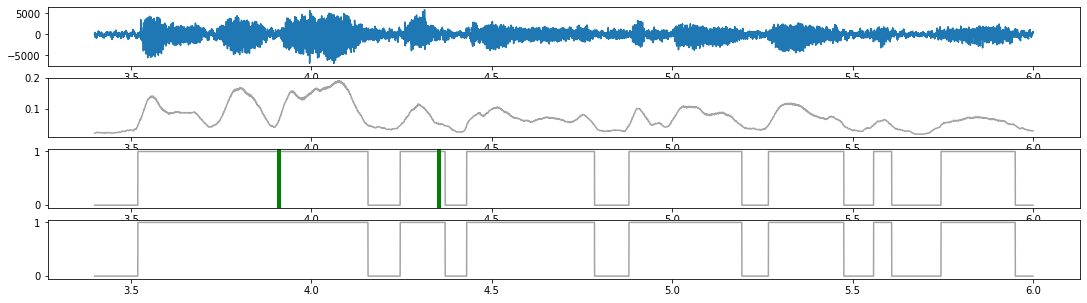

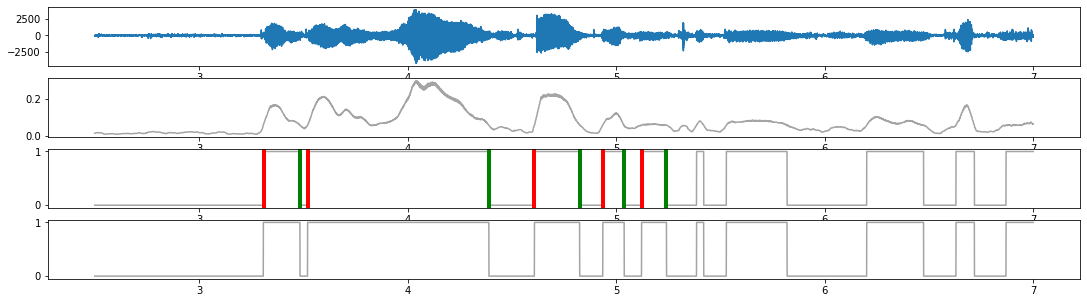

In [57]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01_1 vs 02_1: Bamboo walls are getting to be very popular

(30, 702)
(30, 1504)
distance:  211188.86915379757
16800
[[2895, 12728], [3813, 15133], [4127, 16865], [4127, 18613], [4127, 19488], [4127, 20312], [4150, 20984], [5320, 21943], [5367, 23086], [5367, 23372], [5367, 24229]]


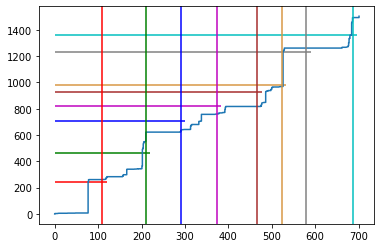

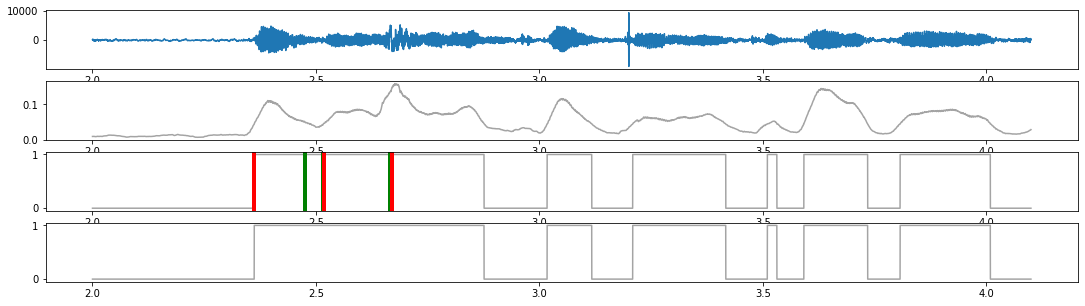

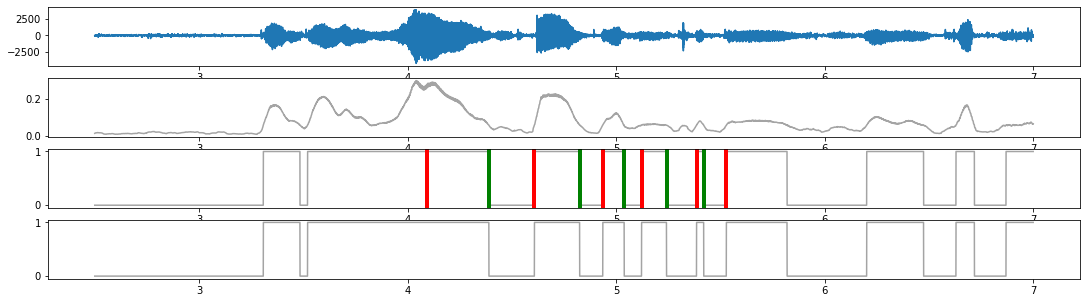

In [58]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01_2 vs 02_1: Bamboo walls are getting to be very popular

(30, 1003)
(30, 1504)
distance:  176552.07682468437
24000
[[2261, 7154], [3065, 9711], [4158, 12669], [4769, 14117], [6249, 16866], [6570, 18651], [6581, 19471], [6945, 20323], [8210, 22670], [8210, 22686], [8468, 23072], [8618, 23378]]


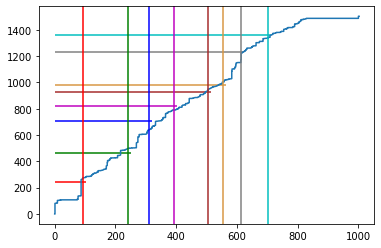

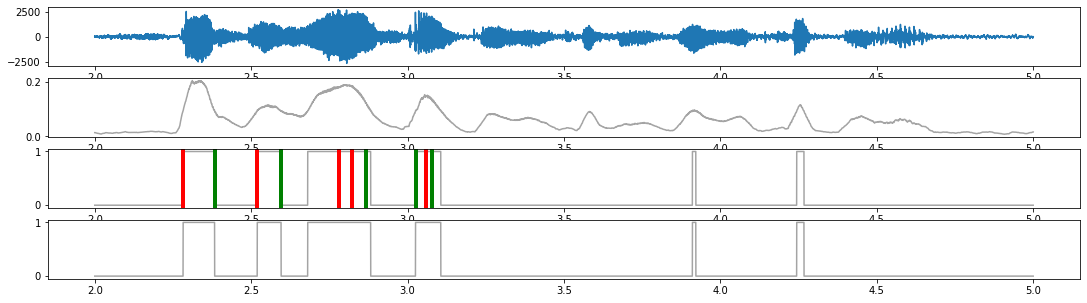

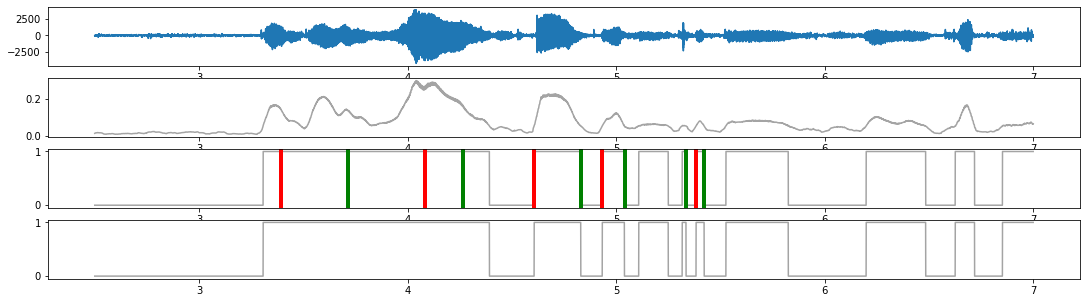

In [59]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]

output(input_min_amp1 = 430, input_min_amp2 = 230, input_min_pause = 30);

# Normal vs Slower: 01_3 vs 02_1: Bamboo walls are getting to be very popular

(30, 669)
(30, 1504)
distance:  307528.73539225344
16000
[[4713, 6473], [4713, 7883], [4713, 8165], [4713, 15120], [4713, 16879], [4713, 18605], [4713, 19502], [4713, 20315], [4713, 20979], [4713, 21941], [4713, 23087], [4713, 23369], [4713, 24232]]


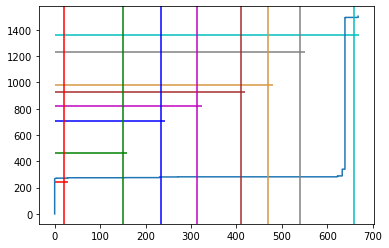

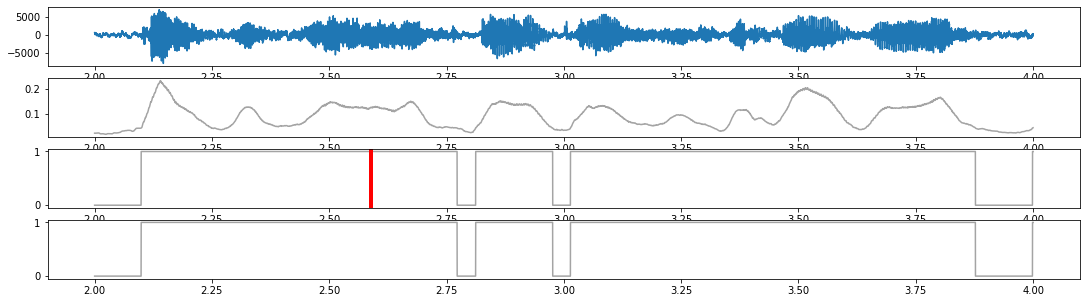

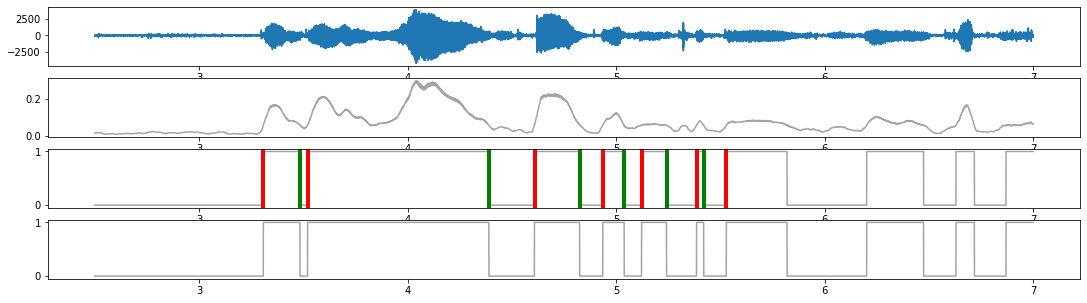

In [60]:
file1, seg1_1, seg1_2 = "01_3.wav", 2, 4
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

time1_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01 vs long_w01: Bamboo walls are getting to be very popular

(30, 1337)
(30, 6515)
distance:  982671.6940738866
32000
[]


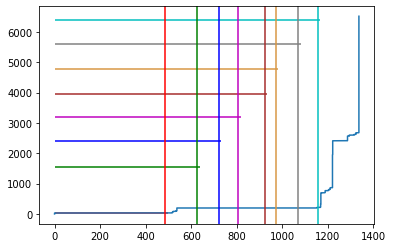

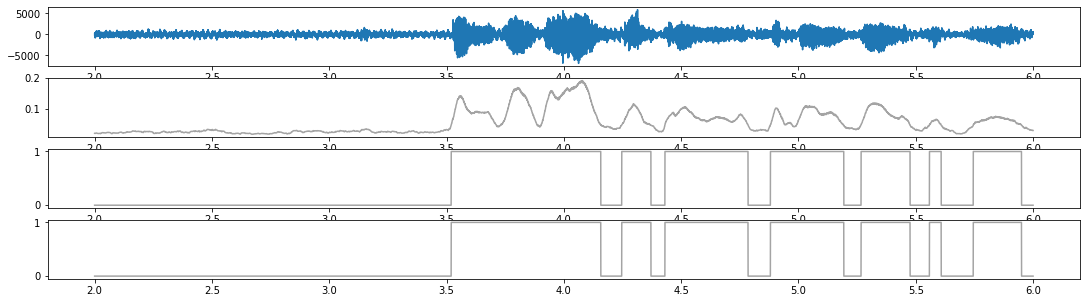

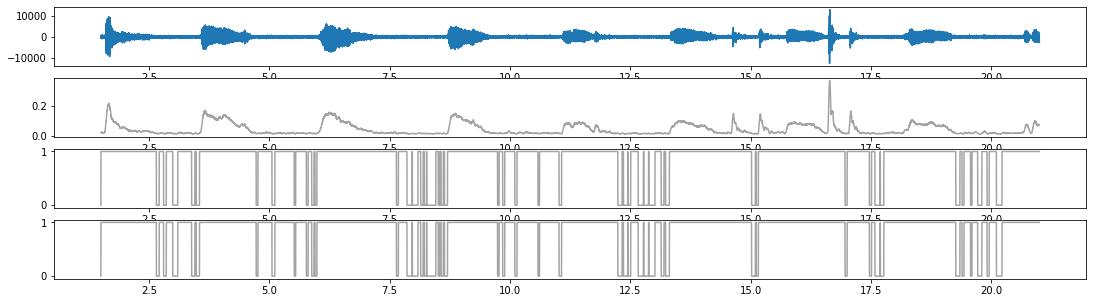

In [61]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "long_w01.wav", 1.5, 21

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.61, 6.12, 8.73, 11.11, 13.33, 15.80, 18.30, 20.72]

output(input_min_amp1 = 500, input_min_amp2 = 200, input_min_pause = 30);

# Bamboo walls: test2 vs test1

(30, 1003)
(30, 1671)
distance:  122991.89165847302
24000
[]


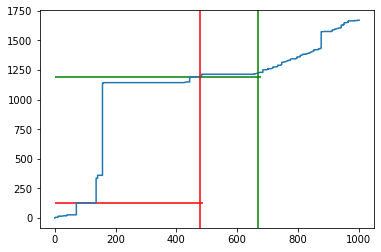

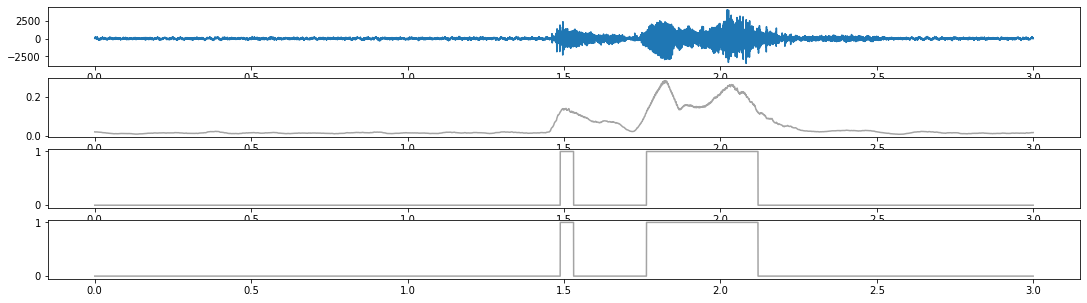

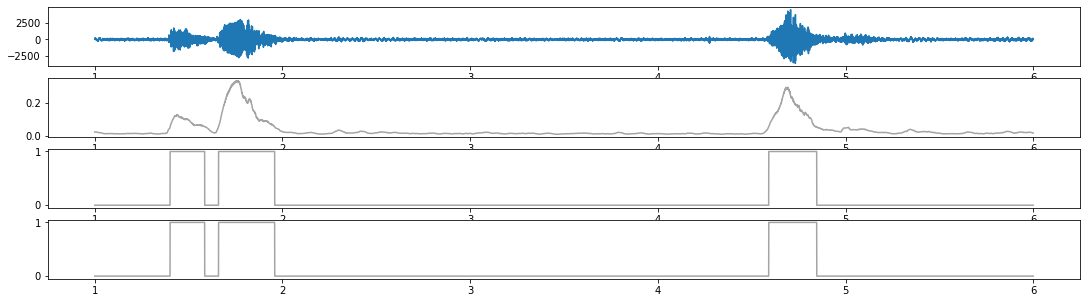

In [62]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test1.wav", 1, 6

time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

(30, 1003)
(30, 1032)
distance:  135066.20392627054
24000
[]


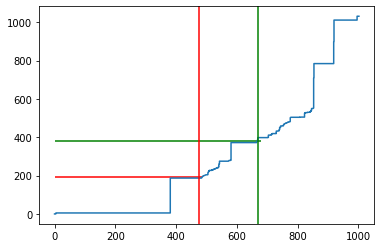

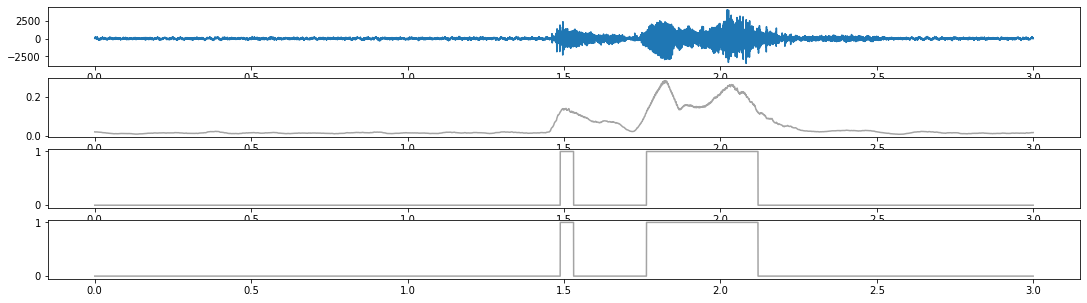

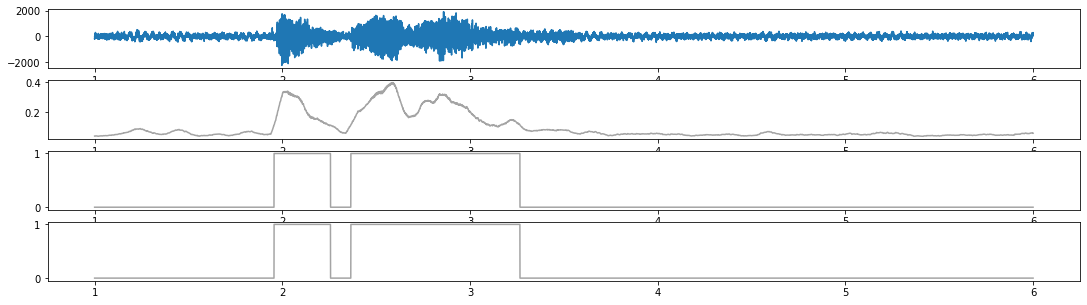

In [63]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test3.wav", 1, 6

time1_lst = [1.43, 2.01]
time2_lst = [1.57, 2.14]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Very Popular vs Very Po Po Popular: 01 vs repeat-syllable01

(30, 268)
(30, 535)
distance:  97353.09125580206
6400
[[536, 131], [973, 1797], [1195, 2540], [1195, 3348], [1195, 5492], [1311, 6680], [1764, 8379]]


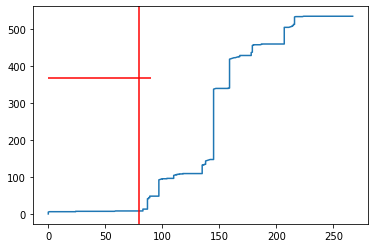

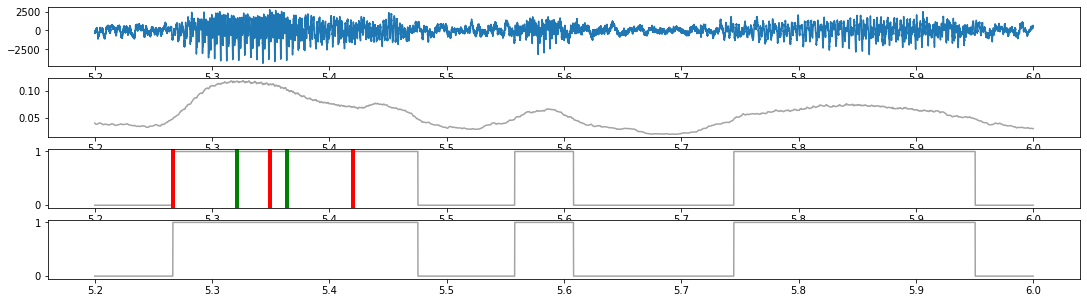

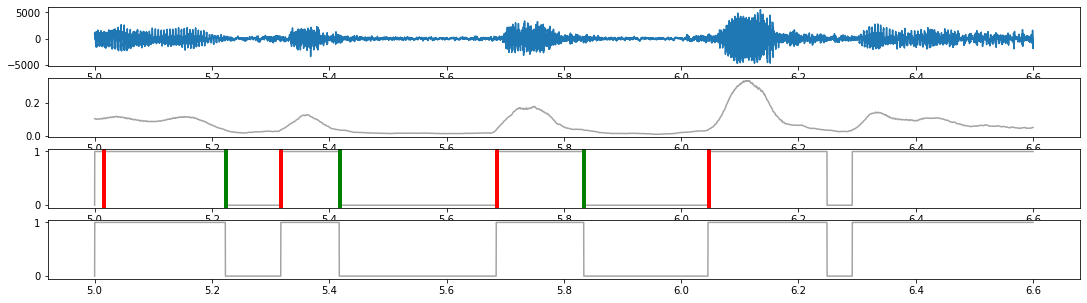

In [64]:
file1, seg1_1, seg1_2 = "01.wav", 5.2, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 5, 6.6

time1_lst = [5.44]
time2_lst = [6.1]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Stutter: B B Bamboo walls are getting to be very po po popular 01 vs repeat-syllable01

(30, 849)
(30, 2005)
distance:  344225.5261358646
20320
[[489, 11910], [927, 13677], [927, 15122], [4898, 22972], [4898, 23821], [5229, 25316], [5229, 25639], [5229, 27831], [5229, 28375], [5581, 28477]]


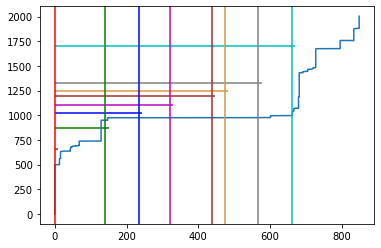

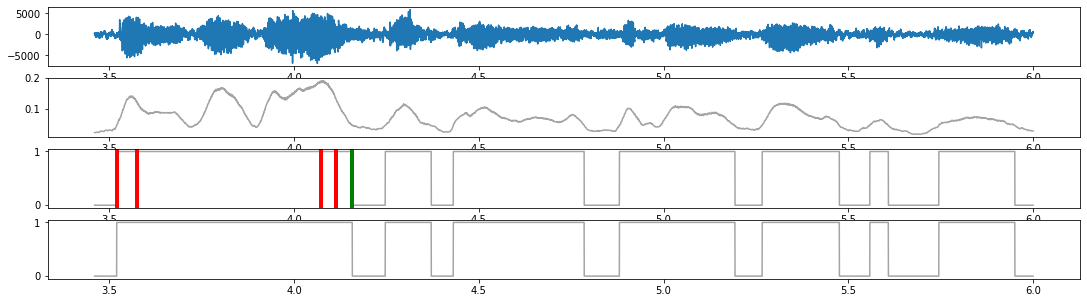

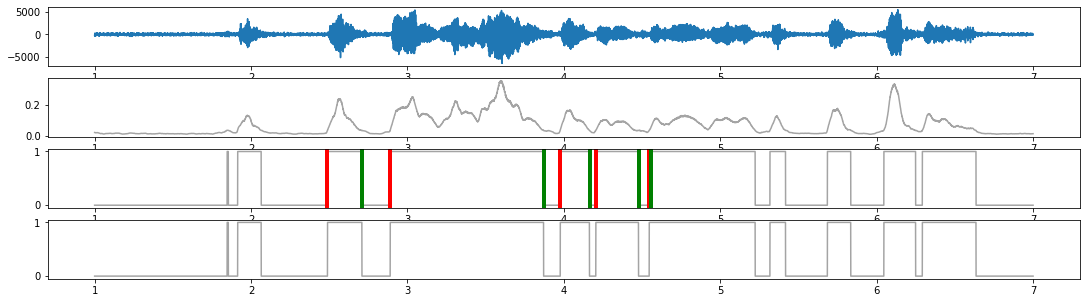

In [65]:
file1, seg1_1, seg1_2 = "01.wav", 3.46, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44] 
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# other random stuff

In [66]:
a = [1, 2, 3, 5, 6, 7, 10, 11, 12, 16, 17, 18, 1757, 1758, 1759, 1760, 1761, 1762]
res = []
res.append(a[0])
for i in range(1, len(a)-1):
    if a[i] - a[i-1] == 1 and a[i+1] - a[i] == 1:
        pass
    else:
        res.append(a[i])

res.append(a[len(a)-1])
print(res)

[1, 3, 5, 7, 10, 12, 16, 18, 1757, 1762]
